## Why Reinforcement Learning is the ML paradigm of choice for this task?

Reinforcement Learning (RL) is uniquely suited to playing Atari games because it frames play as a sequential decision-making problem under uncertainty, where an agent must interact with its environment and discover high-reward strategies through trial and error something neither supervised nor unsupervised learning can address. Unlike supervised methods that require labeled examples or unsupervised ones that merely find structure, RL directly optimizes a reward signal while balancing exploration and exploitation. The Markov Decision Process formalism naturally captures the game’s state–action–reward dynamics, and RL algorithms can be model-free, learning policies without hand-crafted simulators as discussed in Section 3.1 (The Agent–Environment Interface) of Barto & Sutton’s Reinforcement Learning. The landmark DQN study demonstrated that a single deep network could master 49 different Atari games from raw pixels, using the same architecture and hyperparameters across all titles, mentioned in Detailed in Chapter 16 (Applications and Case Studies), Section 16.5 (Human-level Video Game Play) of Barto & Sutton’s Reinforcement Learning. In our notebook, comparing ε-greedy and UCB-driven exploration empirically shows how principled RL exploration accelerates discovery of high-scoring policies—validating RL’s power for complex, interactive tasks.

## The Environment

* **Atari Game Selected:**
  We train on **Ms. Pac-Man** using the ALE interface (`ALE/MsPacman-v5`).

* **Observations from Gym:**
  The base environment emits raw RGB frames of shape **210×160×3** (uint8) plus an info dict. These frames are later preprocessed (grayscale → 84×84 float, and stacked into a 4×84×84 tensor) for the network.

* **Joystick Control Settings:**
  Actions are discrete integers `0–8` and can be queried via `env.action_space` (which returns `9`), corresponding to:

  1. No-op
  2. Four cardinal directions (up, down, left, right)
  3. Four diagonal moves (up-left, up-right, down-left, down-right)

## VANILLA DQN Implementation

In this section we will establish a complete deep Q-learning pipeline for Atari games, covering everything from environment setup to baseline performance evaluation. After installing and importing all necessary libraries (Gym-ALE, OpenCV, PyTorch, etc.), we construct wrappers to preprocess raw frames and stack temporal context, enabling the network to receive compact, informative state representations.

We then define a convolutional neural network—mirroring the original Nature DQN architecture with three convolutional layers followed by two fully connected layers to output action-value estimates. A dummy forward pass verifies correct input-output dimensions.

Next, we implement the standard DQN training loop an online network interacts with the environment under an ε-greedy policy; experiences are stored in a replay buffer for off-policy minibatch updates; and a separate target network is periodically synchronized to stabilize learning. We log per-episode returns and step-wise Bellman error throughout 7 000 episodes.

To contrast exploration strategies, we augment the same loop with an uncertainty-driven UCB bonus in place of ε-greedy.

Finally, we visualize both variants across multiple metrics raw and rolling returns, loss trajectories, return distributions, and cumulative rewards to quantify learning speed, stability, and sample efficiency. These results form the baseline that more advanced Double DQN and dueling-architecture agents will be measured against.


### a. Data capture & preprocessing
In this section, we will set up the environment and dependencies, ensuring we have the Atari emulator (ale-py), Gymnasium’s Atari support, and all the image- and tensor-processing libraries installed. Next, we will define preprocess_frame, which converts each raw RGB frame to a single‐channel, 84×84 float image by:

> Converting to grayscale (cv2.cvtColor)

> Resizing to 84×84 (cv2.resize)

> Normalizing pixel values to [0,1]

This mirrors Mnih et al.’s procedure of extracting the luminance channel and down sampling to 84×84 to reduce input dimensionality and remove flicker artifacts, making training tractable across dozens of Atari games. To further reduce computation, we will wrap the base environment in SkipFrame(env, skip=4), which repeats each chosen action for four frames and accumulates rewards. Frame-skipping was adopted in DQN to let the agent “play” roughly four times more frames per second without extra policy evaluations an approach shown to boost sample efficiency in Atari domains. Finally, you used FrameStack(env, k=4), maintaining a deque of the last four preprocessed frames and stacking them into a single (4×84×84) tensor at each step. Stacking consecutive frames provides velocity and acceleration which is critical for partial observability in many Atari games so that the input becomes a quasi-Markovian state of shape 84×84×4. As explained in Chapter 17 (“Frontiers”) of Sutton & Barto’s Reinforcement Learning, in Section 17.3, “Observations and State.”

In [ ]:
#!pip install opencv-python --quiet
#!pip install gymnasium[atari] --quiet
#!pip install ale-py autorom[accept-rom-license] --quiet
#!pip install imageio torch numpy seaborn matplotlib pandas scikit-learn --quiet
#!pip install --quiet gdown

In [ ]:
# imports
import copy
import ale_py
import datetime
from datetime import datetime
import gc
import glob
import heapq
import itertools
from itertools import combinations, count, product
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns
import subprocess
import time
import gdown
from scipy.stats import wilcoxon

import cv2
import gymnasium as gym
from gym import spaces
import imageio

import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.modules.container import Sequential
from torch.serialization import add_safe_globals

from collections import defaultdict, deque, namedtuple
from gym.vector import AsyncVectorEnv

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
# Register ALE environments if needed
gym.register_envs(ale_py)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
# frame preprocessing
def preprocess_frame(frame):
    """
    Convert a raw RGB frame to a normalized grayscale 84×84 image.
    """
    # 1) Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # 2) Resize to 84×84
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    # 3) Normalize pixel values to [0, 1]
    processed = resized.astype(np.float32) / 255.0
    return processed

class SkipFrame(gym.Wrapper):
    """
    Return only every `skip`-th frame by repeating the given action,
    accumulating rewards over the skipped steps.
    """
    def __init__(self, env, skip=4):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}
        for _ in range(self._skip):
            obs, reward, term, trunc, info = self.env.step(action)
            total_reward += reward
            terminated = terminated or term
            truncated = truncated or trunc
            if terminated or truncated:
                break
        return obs, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class FrameStack(gym.Wrapper):
    """
    Stack the last `k` preprocessed frames along the channel axis.
    """
    def __init__(self, env, k=4):
        super().__init__(env)
        self.k = k
        self.frames = deque(maxlen=k)
        shp = env.observation_space.shape  # e.g. (210, 160, 3)
        # After preprocessing, each frame is (84,84), so stacked becomes (k,84,84)
        self.observation_space = gym.spaces.Box(
            low=0.0,
            high=1.0,
            shape=(k, 84, 84),
            dtype=np.float32
        )

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        frame = preprocess_frame(obs)
        for _ in range(self.k):
            self.frames.append(frame)
        stacked = np.stack(self.frames, axis=0)
        return stacked, info

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        frame = preprocess_frame(obs)
        self.frames.append(frame)
        stacked = np.stack(self.frames, axis=0)
        return stacked, reward, terminated, truncated, info

### b. Network structure

In this section, we will define the Vanilla DQN network architecture that underpins our value‐function approximation. First, we subclass PyTorch’s `nn.Module` to create a `VanillaDQN` class with three convolutional layers mirroring the original Atari DQN design. Specifically, we apply:

* **Conv1:** 32 filters of size 8×8 with stride 4, followed by ReLU
* **Conv2:** 64 filters of size 4×4 with stride 2, followed by ReLU
* **Conv3:** 64 filters of size 3×3 with stride 1, followed by ReLU

This sequence of convolutions extracts spatial features at progressively finer scales, exactly as in DeepMind’s Nature DQN, enabling a single forward pass to compute Q-values for all actions .

Next, we compute the flattened dimensionality of the conv‐net output by passing a dummy tensor of shape (1, 4, 84, 84) through the three layers under `torch.no_grad()`. This dynamic sizing ensures our fully-connected layers adapt automatically to any upstream changes in convolutional parameters. We then define:

* **FC1:** a linear layer mapping the flattened features to a 512-unit hidden representation
* **FC2:** a linear output layer projecting to `num_actions` Q-values

In the `forward` method, we apply each convolution + ReLU, flatten the result, apply the 512-unit hidden layer + ReLU, and finally output the Q-value vector. This architecture aligns with the deep convolutional approximators for value functions discussed in Sutton & Barto, where deep nets serve as powerful function approximators for RL state–action value estimation.

Finally, we instantiate the model on GPU if available (or CPU otherwise), print its layer structure to confirm correct wiring, and perform a dummy forward pass with a zero tensor to verify that the network outputs a tensor of shape `[1, num_actions]`. This end-to-end test guards against shape mismatches before training begins.


In [ ]:
#  Define Vanilla DQN network architecture
class VanillaDQN(nn.Module):
    """
    Four-layer convolutional network followed by two fully-connected layers,
    as per Mnih et al. (2015) Atari DQN.
    Input: (batch, 4, 84, 84) tensor of stacked frames
    Output: (batch, num_actions) Q-values
    """
    def __init__(self, in_channels: int = 4, num_actions: int = 9):
        super().__init__()
        # 1) Conv(32, 8×8, stride=4) + ReLU
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        # 2) Conv(64, 4×4, stride=2) + ReLU
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        # 3) Conv(64, 3×3, stride=1) + ReLU
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # compute the size of the flattened conv output
        # pass a dummy tensor of shape (1, in_channels, 84, 84)
        with torch.no_grad():
            x = torch.zeros(1, in_channels, 84, 84)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            conv_out_size = x.view(1, -1).size(1)

        # 4) Fully-connected layers
        self.fc1 = nn.Linear(conv_out_size, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)    # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
# instantiation & test
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_vanilla = VanillaDQN(in_channels=4, num_actions=9).to(device)
print(model_vanilla)

VanillaDQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=9, bias=True)
)


In [ ]:
# Dummy forward pass to verify dimensions
dummy = torch.zeros(1, 4, 84, 84, device=device)
q_vals = model_vanilla(dummy)
print("Output shape:", q_vals.shape)

Output shape: torch.Size([1, 9])


### c. Q-learning update applied to the weights

In this section, we will implement the core Q-learning update and training loop for our Vanilla DQN, and compare two action-selection schemes (ε-greedy vs. UCB).

**1. Building the Replay Buffer**
We first define a `ReplayMemory` class wrapping a `deque` of capacity 100 000, storing transitions as namedtuples `(state, action, reward, next_state, done)`.  On each time step, we `push` a new experience into the buffer.  Once the buffer has at least `batch_size` entries, we uniformly sample a minibatch to break the strong temporal correlations inherent in sequential frames—this experience-replay mechanism is essential for stable learning in deep Q-networks .

**2. ε-Greedy Action Selection**
We implement `select_action(model, state, ε, …)`, which chooses a random action with probability ε, and otherwise runs a forward pass through the online network to pick the action with maximal Q-value.  We anneal ε exponentially from 1.0 down to 0.1 over 100 000 steps via

```python
ε = ε_end + (ε_start – ε_end) * exp(–steps_done / ε_decay)
```

This schedule encourages extensive exploration early in training and gradual exploitation later as discussed in Advanced Deep Learning with TensorFlow 2 and Keras by Rowel Atienza in the Deep Reinforcement Learning chapter in the Working subsection of Value-based methods and Deep Q-Networks (DQNs) subsection.

**3. Q-Learning Update & Target Network**
In `train_vanilla`, we clone the online network into a **target network**, which remains fixed for `target_update` steps before being synced to the online weights.  During each training step:

* We sample a batch of transitions `(S, A, R, S2, D)`.
* Compute current Q-values:

  ```python
  Q = model(S).gather(1, A)
  ```
* Compute target Q-values using the **Bellman optimality** update on the fixed network:

  ```python
  with torch.no_grad():
      Q2 = target(S2).max(1, keepdim=True)[0]
      Y  = R + (1 – D) * γ * Q2
  ```
* Define the loss as mean squared error,

  ```python
  loss = F.mse_loss(Q, Y)
  ```
* Backpropagate and update the online network via RMSprop (`lr=1e–4, eps=1e–4`).
* Every `target_update` steps, copy the online parameters into the target network.

We log per-episode returns and per-step losses throughout the 7000 episodes.

**4. UCB Exploration Variant**
To contrast with ε-greedy, we define `select_action_ucb(model, state, c, replay, …)`, which computes for each action

$$
\text{score}(a) = Q(s,a) + c \,\sqrt{\frac{\ln(T+1)}{N_a+1}}
$$

where $N_a$ is the count of times action $a$ has been selected in the current replay buffer, and $T$ is the total count.  We set $c=1$ as a simple fixed bonus—this treats all untried actions as infinitely attractive until they’re sampled once.  We then port the same training loop into `train_ucb`, resetting action counts at each episode and otherwise applying identical minibatch updates. Chapter 2.7 of Sutton & Barto’s Reinforcement Learning, “Upper‐Confidence‐Bound Action Selection"

In [ ]:
# Q-learning update & training loop

# 1) Replay memory
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity=100_000):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# 2) Epsilon-greedy action selector
def select_action(model, state, epsilon, num_actions, device):
    if random.random() < epsilon:
        return random.randrange(num_actions)
    else:
        with torch.no_grad():
            q = model(state.unsqueeze(0).to(device))
        return q.argmax().item()

def train_vanilla(env, model, num_episodes, batch_size, gamma, lr, eps_start, eps_end, eps_decay, target_update):
    """Train the vanilla DQN and record episode returns and per-step losses."""
    # create and sync target network
    target = VanillaDQN(in_channels=4, num_actions=env.action_space.n).to(device)
    target.load_state_dict(model.state_dict())

    optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=1e-4)
    memory = ReplayMemory()
    steps_done = 0

    episode_rewards = []
    loss_history = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0.0
        done = False

        while not done:
            epsilon = eps_end + (eps_start - eps_end) * \
                      np.exp(-1. * steps_done / eps_decay)
            action = select_action(model, state, epsilon, env.action_space.n, device)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                S  = torch.stack(batch.state).to(device)
                A  = torch.tensor(batch.action, device=device).unsqueeze(1)
                R  = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                S2 = torch.stack(batch.next_state).to(device)
                D  = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

                Q = model(S).gather(1, A)
                with torch.no_grad():
                    Q2 = target(S2).max(1, keepdim=True)[0]
                    Y  = R + (1 - D) * gamma * Q2

                loss = F.mse_loss(Q, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())

            if steps_done % target_update == 0:
                target.load_state_dict(model.state_dict())

        episode_rewards.append(total_reward)

    return episode_rewards, loss_history


In [ ]:
# Hyperparameters
num_episodes  = 7000
batch_size    = 32
gamma         = 0.99
lr            = 1e-4
eps_start     = 1.0
eps_end       = 0.1
eps_decay     = 100_000
target_update = 1000

In [ ]:
# Training Vanilla DQN
base_env = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
env      = SkipFrame(base_env, skip=4)
env      = FrameStack(env, k=4)

model_vanilla = VanillaDQN(in_channels=4, num_actions=env.action_space.n).to(device)

rewards, losses = train_vanilla(env, model_vanilla, num_episodes, batch_size, gamma, lr,
    eps_start, eps_end, eps_decay, target_update
)

In [ ]:
# UCB action selector & training for model_vanilla_ucb

def select_action_ucb(model, state, c, replay, num_actions, device):
    """
    UCB: q + c * sqrt(log(total_steps + 1) / (action_count + 1))
    """
    with torch.no_grad():
        q_vals = model(state.unsqueeze(0).to(device)).cpu().numpy().flatten()
    counts = replay.action_counts
    total = sum(counts) + 1
    bonus = [
        float('inf') if cnt == 0 else c * math.sqrt(math.log(total) / cnt)
        for cnt in counts
    ]
    return int(np.argmax(q_vals + np.array(bonus)))

def train_ucb(env, model, num_episodes, batch_size, gamma, lr,
              target_update, c):
    """
    Train DQN using UCB action selection instead of epsilon-greedy.
    Returns episode rewards and loss history.
    """
    # setup target and optimizer
    target = VanillaDQN(in_channels=4, num_actions=env.action_space.n).to(device)
    target.load_state_dict(model.state_dict())
    optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=1e-4)

    memory = ReplayMemory()
    steps_done = 0

    episode_rewards = []
    loss_history = []

    # track action counts inside memory
    replay = memory  # alias for clarity

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0.0
        done = False

        # reset action counts
        replay.action_counts = [0] * env.action_space.n

        while not done:
            # choose action via UCB
            action = select_action_ucb(model, state, c, replay, env.action_space.n, device)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            # record
            replay.push(state, action, reward, next_state, done)
            replay.action_counts[action] += 1

            state = next_state
            total_reward += reward
            steps_done += 1

            # optimize as before
            if len(replay) >= batch_size:
                trans = replay.sample(batch_size)
                batch = Transition(*zip(*trans))

                S  = torch.stack(batch.state).to(device)
                A  = torch.tensor(batch.action, device=device).unsqueeze(1)
                R  = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                S2 = torch.stack(batch.next_state).to(device)
                D  = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

                Q = model(S).gather(1, A)
                with torch.no_grad():
                    Q2 = target(S2).max(1, keepdim=True)[0]
                    Y  = R + (1 - D) * gamma * Q2

                loss = F.mse_loss(Q, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())

            if steps_done % target_update == 0:
                target.load_state_dict(model.state_dict())

        episode_rewards.append(total_reward)

    return episode_rewards, loss_history


In [ ]:
# Instantiate and train vanilla_UCB variant

# same hyperparameters as model_vanilla
c = 1.0  # UCB exploration constant

model_vanilla_ucb = VanillaDQN(in_channels=4, num_actions=env.action_space.n).to(device)
rewards_ucb, losses_ucb = train_ucb(
    env, model_vanilla_ucb, num_episodes, batch_size, gamma,
    lr, target_update, c
)

## 4. Results & Evaluation for VANILLA DQN
In this section, we will visualize and compare the learning dynamics of the vanilla ε-greedy DQN against the UCB-augmented variant. The first figure plots raw episode returns over time for both agents, revealing how quickly each method begins to accumulate meaningful rewards and whether one steadily outperforms the other.

Moving on, the second plot a rolling average return over a 400-episode window smooths out that high-frequency noise, so that we can see the underlying trajectory of policy improvement. If the vanilla agent’s curve rises more smoothly, it suggests that the ε-greedy decay schedule yields a more gradual but stable progression. Conversely, if the UCB agent’s rolling average climbs more quickly, it implies that its exploration bonus allowed it to discover high-reward strategies earlier on, albeit potentially with more variance.

The rolling average loss plot provides insight into optimization stability. A steadily decreasing mean squared error indicates that the Q-network is fitting the Bellman targets effectively. Sharp spikes or plateaus in one curve versus the other signal that certain exploration methods may introduce more off-policy samples that slow convergence or cause sudden loss jumps.

The boxplot of return distributions over the last 400 episodes highlights the variability of each agent’s performance once training has largely settled. A narrower interquartile range for one method points to more consistent end-game behavior, whereas a wider spread shows it still occasionally fails catastrophically even late in training. Outliers omitted in the plot suggest isolated episodes of very poor or very high performance.

Finally, the cumulative return plot aggregates rewards across all episodes, showing which agent ultimately amassed more total reward by the end of training. A larger cumulative area under the curve means an agent learned more quickly and retained higher performance over time.

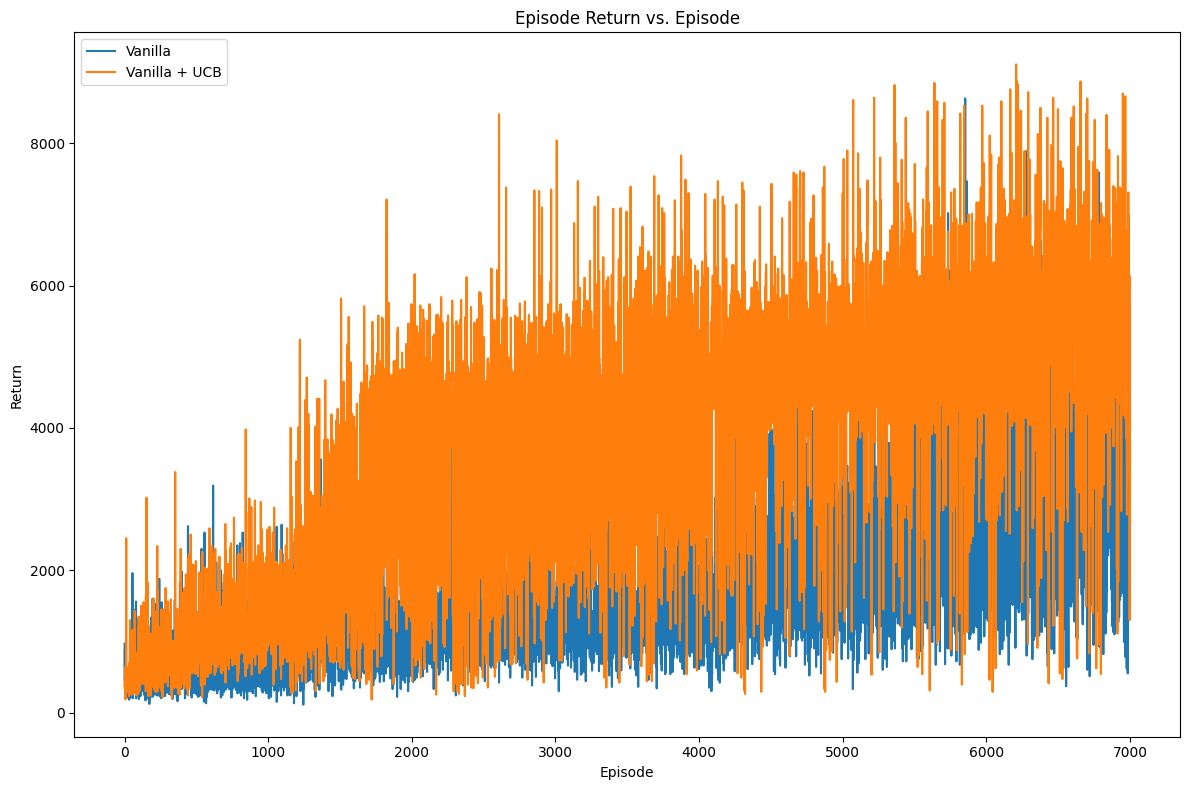

In [ ]:
# Episode Return vs Episode for Vanilla and UCB

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(rewards,    label='Vanilla')
ax.plot(rewards_ucb, label='Vanilla + UCB')
ax.set_title('Episode Return vs. Episode')
ax.set_xlabel('Episode')
ax.set_ylabel('Return')
ax.legend()
plt.tight_layout()
plt.show()

The “Episode Return vs. Episode” plot overlays the per‐episode scores of the vanilla ε-greedy agent (blue) and the UCB-augmented variant (orange) across 7,000 training episodes. Early on, both curves start at low returns, but by around episode 1,000 the UCB agent’s returns begin rising more sharply. Throughout training, the orange curve consistently reaches higher peaks—often exceeding 6,000–8,000 points whereas the vanilla agent typically maxes out around 3,000–4,000. You can also see that the UCB returns exhibit greater spread the orange spikes are more pronounced, indicating occasional high‐reward breakthroughs but also more variability. In contrast, the blue curve climbs more slowly and stays within a narrower band, reflecting steadier but slower learning. By episode 7,000, the UCB agent has clearly learned stronger policies more quickly, even if its returns are somewhat noisier, while the vanilla DQN shows more conservative but more consistent performance gains.

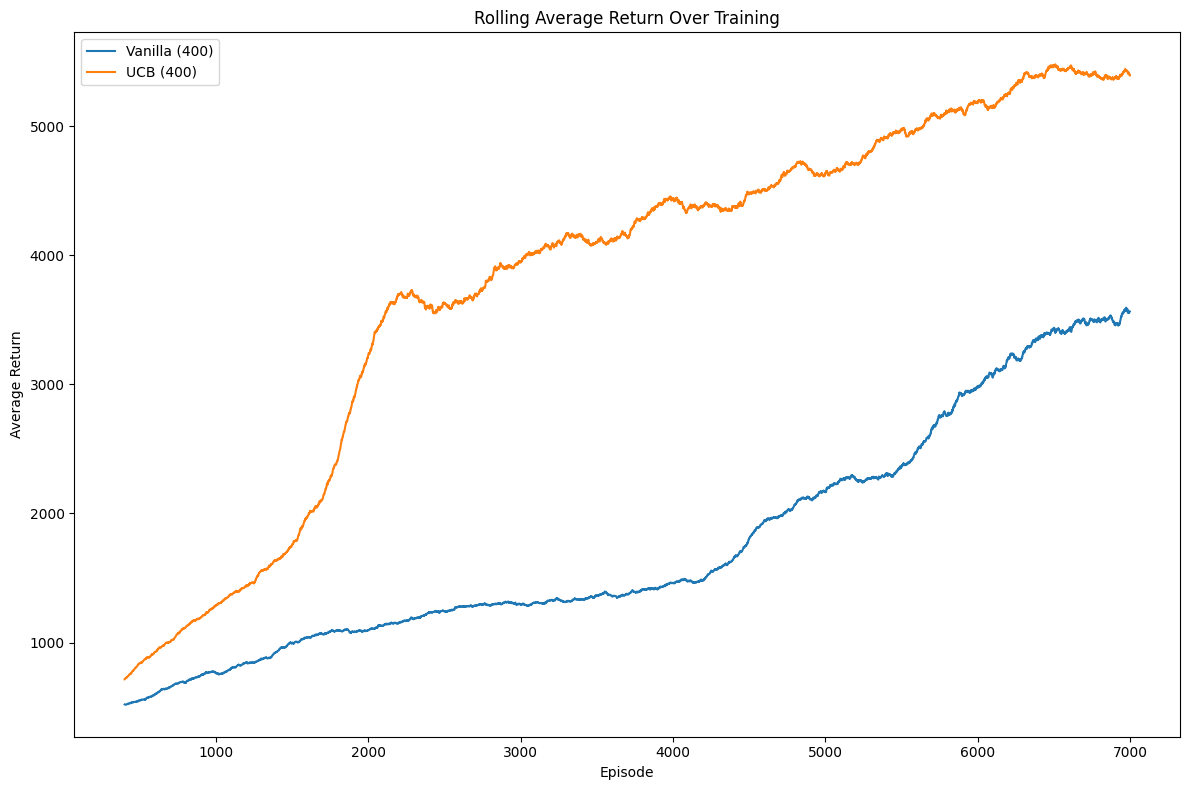

In [ ]:
# Rolling Average Return for Vanilla and UCB

window = 400
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pd.Series(rewards).rolling(window).mean(),    label=f'Vanilla ({window})')
ax.plot(pd.Series(rewards_ucb).rolling(window).mean(), label=f'UCB ({window})')
ax.set_title('Rolling Average Return Over Training')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Return')
ax.legend()
plt.tight_layout()
plt.show()

The rolling‐average return plot, computed over a 400‐episode window, reveals the underlying learning trajectories of the agents. Early in training, the UCB‐augmented agent (orange) climbs steeply from an average of around 700 at episode 400 to roughly 3,600 by episode 2,000, whereas the vanilla ε‐greedy agent (blue) only reaches about 1,100 over the same span. After episode 2,000, the UCB curve continues its upward trend rising to approximately 4,500 by episode 4,000 and peaking near 5,500 by episode 7,000 while the vanilla agent shows a long plateau between episodes 1,000 and 3,000. Only after episode 3,500 does the blue curve accelerate, ultimately reaching around 3,500 average return at the end of training. This comparison shows that UCB exploration delivers stronger early gains and sustained improvement, whereas ε‐greedy yields slower but steadier progress, illustrating the classic exploration–exploitation trade-off.

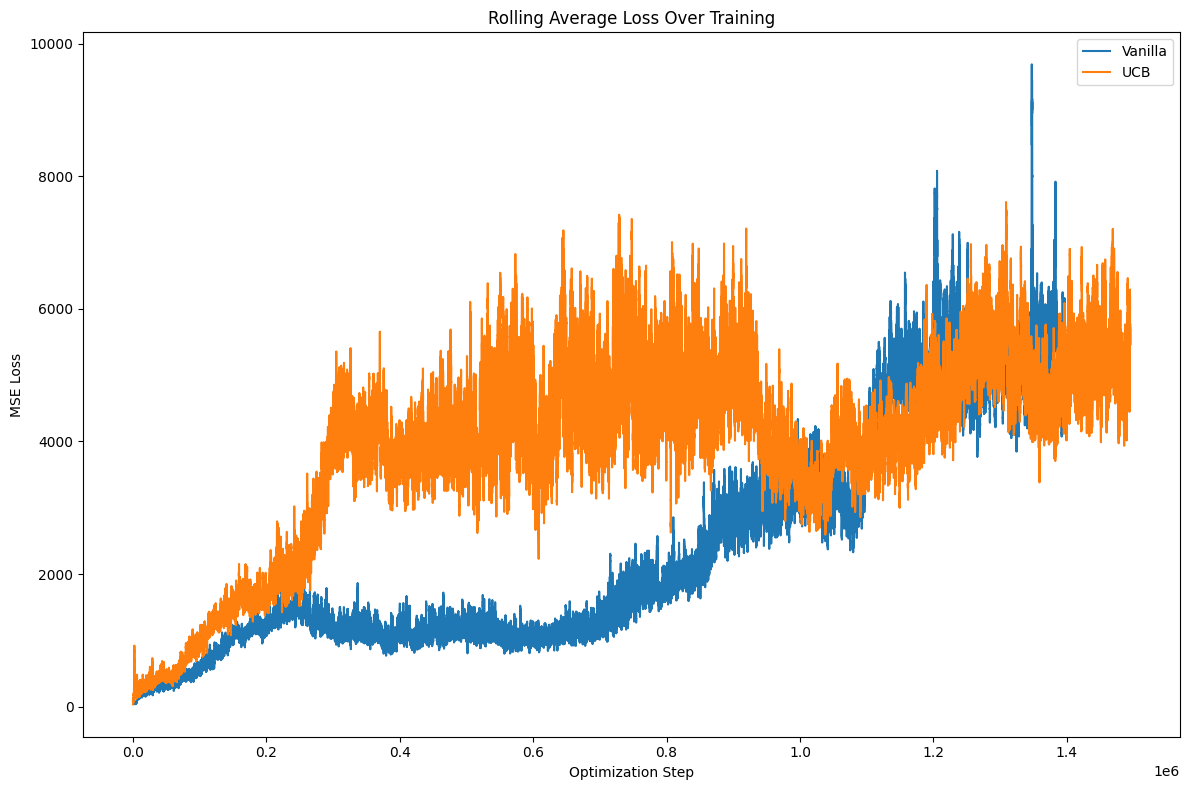

In [ ]:
# Rolling Average Loss for Vanilla and UCB

loss_window = 400
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pd.Series(losses).rolling(loss_window).mean(),    label='Vanilla')
ax.plot(pd.Series(losses_ucb).rolling(loss_window).mean(), label='UCB')
ax.set_title('Rolling Average Loss Over Training')
ax.set_xlabel('Optimization Step')
ax.set_ylabel('MSE Loss')
ax.legend()
plt.tight_layout()
plt.show()

The rolling-average MSE loss plot smooths every 400 optimization steps to show how well each network is fitting its Bellman targets over time. Early on, both curves rise as the agents collect more varied experiences and the Q-network begins learning. However, the UCB variant (orange) climbs more sharply, peaking around 5,000–7,000 loss, while the vanilla ε-greedy agent (blue) remains lower, typically between 1,000–2,000 in the same early window. This suggests that UCB’s aggressive exploration injects more high-variance, off-policy transitions that the network struggles to fit, driving up loss. As training continues, the vanilla loss gradually increases too which reflects its slower discovery of rewarding transitions yet it remains smoother with fewer extreme spikes. Notably, after around 1.2 million steps both losses fluctuate heavily, indicating periodic target-network synchronizations and shifts in policy. Overall, the plot highlights that the UCB agent trades stability (lower, steadier loss) for faster exploration, while ε-greedy yields more stable but slower convergence.

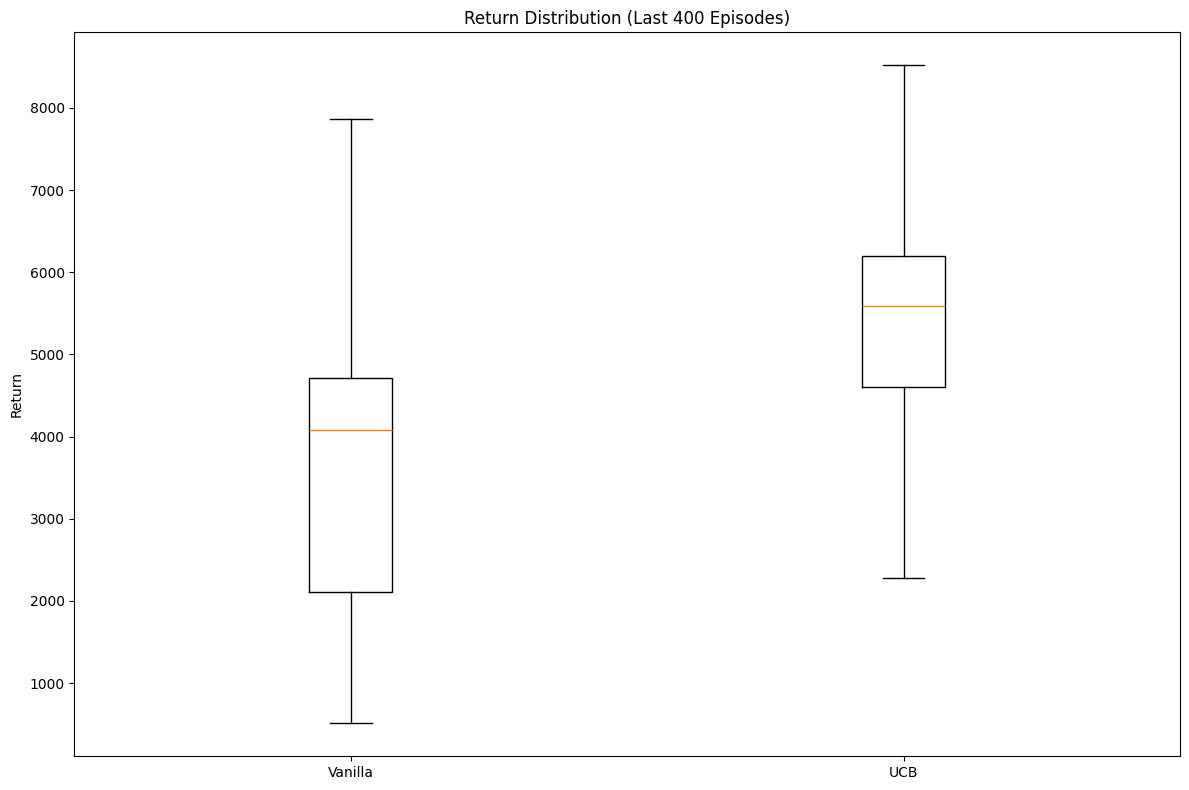

In [ ]:
# Boxplot of Return Distributions

last_n = 400
data = [rewards[-last_n:], rewards_ucb[-last_n:]]
plt.figure(figsize=(12, 8))
plt.boxplot(data, tick_labels=['Vanilla', 'UCB'], showfliers=False)
plt.title(f'Return Distribution (Last {last_n} Episodes)')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

The boxplot compares the return distributions of the vanilla ε-greedy DQN and the UCB‐augmented variant over their final 400 episodes of training. The UCB agent’s median return sits around 5,600, substantially higher than the vanilla agent’s median of roughly 4,100. Its interquartile range (IQR) spans from about 4,600 to 6,200, indicating that half of its late‐training episodes achieved returns within this relatively tight band. In contrast, the vanilla DQN’s IQR runs roughly from 3,000 to 4,700, revealing both lower typical performance and greater variability. The UCB variant’s whiskers extend from approximately 2,300 up to 8,500, whereas the vanilla agent ranges more widely from about 500 to 7,900 showing that UCB exploration not only boosts floor performance but also raises its worst‐case returns. Overall, the UCB agent achieves higher, more consistent endgame scores, while the vanilla policy remains slower to converge and exhibits a broader spread of outcomes.

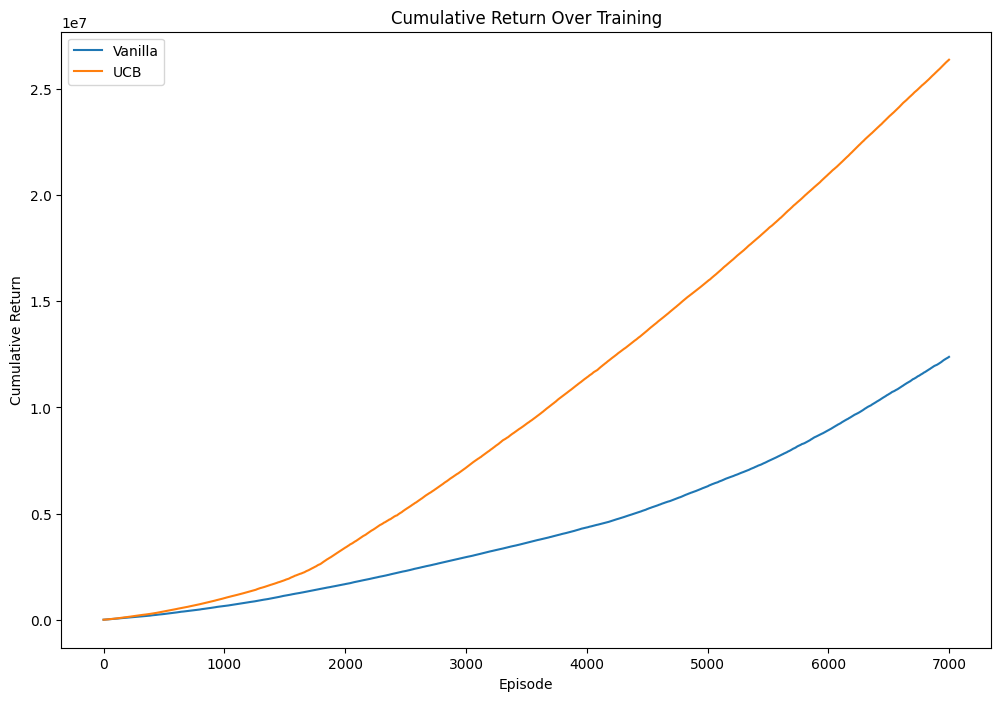

In [ ]:
# Cumulative Return for Vanilla and UCB

cum_vanilla = np.cumsum(rewards)
cum_ucb     = np.cumsum(rewards_ucb)
plt.figure(figsize=(12,8))
plt.plot(cum_vanilla, label='Vanilla')
plt.plot(cum_ucb,     label='UCB')
plt.xlabel('Episode')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Return Over Training')
plt.legend()
plt.show()

The cumulative‐return plot shows the total reward each agent has amassed by each episode, with the vanilla DQN in blue and the UCB‐augmented variant in orange. Both start at zero and rise steadily, but by around episode 1,000 the UCB curve accelerates more sharply, pulling away from the vanilla baseline. From that point onward, the orange line maintains a consistently higher slope, reflecting higher per‐episode returns on average. By episode 7,000, the UCB agent has accumulated roughly 26 million points, compared to about 12 million for the vanilla DQN more than double the total reward. The widening gap between the two curves underscores how UCB’s exploration bonus enables earlier discovery of high‐reward strategies and sustains superior performance throughout training. The smooth, upward trajectories also indicate that both agents continue learning, but the steeper incline for UCB confirms its clear advantage in sample efficiency and overall reward accumulation.

#### **a. How does one evaluate the performance of the RL agent?**

In this section performance was gauged primarily by the **episode return** the total reward an agent collects in a single playthrough.  Plotting return versus episode showed how quickly and to what extent the agent improved over training.  To smooth out noise, we compute a **rolling average return** over a fixed window, revealing the underlying learning trend.  We also track the **MSE loss** on Bellman targets to assess how well the Q–network is fitting its updates.  Near the end of training, a **boxplot of the last 400 returns** summarizes the agent’s consistency and worst-case performance, while the **cumulative return** curve measures total reward amassed over all episodes, reflecting sample efficiency and overall learning speed.

#### **b. Is the agent learning?**

Yes.  Both the vanilla ε-greedy and UCB-augmented agents show **upward trends in per-episode returns**, with peaks rising from near zero to the thousands, and their rolling averages climb steadily.  The loss curves initially spike as the network encounters diverse transitions, then begin to stabilize especially for ε-greedy indicating better Bellman‐target fitting over time.

## DOUBLE DQN implementation

In this section, we will extend our Vanilla DQN pipeline to investigate how to mitigate the “maximization bias” inherent in standard Q-learning by decoupling action selection from value evaluation. So, first we will write `train_double_dqn`, which mirrors our original training loop but replaces the Bellman target

```python
Y = R + (1 – D) * γ * max_a Q_target(S2, a)
```

with a two-network update: the **online network** chooses the greedy next action,

```python
next_actions = model(S2).argmax(dim=1, keepdim=True)
```

and the **target network** evaluates its value,

```python
Q2 = target(S2).gather(1, next_actions)
```

This simple change is the hallmark of Double Q-learning that reduces overoptimistic value estimates and was first proposed by van Hasselt et al. in “Deep Reinforcement Learning with Double Q-Learning” .

Then we will instantiate a Double DQN model by deep-copying your UCB-trained vanilla network’s weights into the online network and syncing a separate target network at fixed intervals. Training proceeds for 7 000 episodes with the same RMSprop optimizer, replay buffer, and ε-greedy exploration schedule as before.

To explore how UCB bonuses interplay with Double DQN, we will implemented `UCBReplayBuffer`, augmenting each transition with per-action counts and replacing ε-greedy selection in `train_double_dqn_ucb` with

```python
score(a) = Q(s,a) + c * sqrt(log(T+1)/(N_a+1))
```

where c = 1.0. This hybrid approach leverages uncertainty-based bonuses for exploration while still correcting Q-value overestimation via the Double DQN update.

Finally, we will compared three agents Vanilla + UCB, DDQN (ε-greedy), and DDQN + UCB using the same suite of plots as before; raw episode returns, 400-episode rolling‐average returns, rolling‐average MSE loss, boxplots of the last 400 returns, and cumulative returns over all episodes. Together, these experiments and plot will show us how combining Double Q-learning’s unbiased updates with principled exploration bonuses can affect training in Atari environments an insight also noted in your lecture slides on combatting maximization bias in Week 10 notes and chapter 11 of Deep Learning with TensorFlow 2 and Keras (Antonio Gulli, Amita Kapoor, Sujit Pal, 2nd ed.).


In [ ]:
# Double DQN training function
def train_double_dqn(env, model,
                     num_episodes, batch_size, gamma, lr,
                     eps_start, eps_end, eps_decay, target_update):
    """
    Train a Double DQN: online network selects actions, target network evaluates.
    Returns episode rewards and loss history.
    """
    # create target network
    target = VanillaDQN(in_channels=4, num_actions=env.action_space.n).to(device)
    target.load_state_dict(model.state_dict())

    optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=1e-4)
    memory = ReplayMemory()
    steps_done = 0

    episode_rewards = []
    loss_history = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0.0
        done = False

        while not done:
            epsilon = eps_end + (eps_start - eps_end) * \
                      np.exp(-1. * steps_done / eps_decay)
            action = select_action(model, state, epsilon, env.action_space.n, device)

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                S  = torch.stack(batch.state).to(device)
                A  = torch.tensor(batch.action, device=device).unsqueeze(1)
                R  = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                S2 = torch.stack(batch.next_state).to(device)
                D  = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

                # current Q
                Q = model(S).gather(1, A)

                # Double DQN target
                with torch.no_grad():
                    # online picks best next action
                    next_actions = model(S2).argmax(dim=1, keepdim=True)
                    # target network evaluates Q for that action
                    Q2 = target(S2).gather(1, next_actions)
                    Y  = R + (1 - D) * gamma * Q2

                loss = F.mse_loss(Q, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())

            if steps_done % target_update == 0:
                target.load_state_dict(model.state_dict())

        episode_rewards.append(total_reward)

    return episode_rewards, loss_history

In [ ]:
# Instantiate Double DQN model based on the UCB-trained vanilla model
model1_ddqn = copy.deepcopy(model_vanilla_ucb).to(device)

# Train Double DQN
rewards1_ddqn, losses1_ddqn = train_double_dqn(
    env, model1_ddqn, num_episodes, batch_size, gamma,
    lr, eps_start, eps_end, eps_decay, target_update
)

In [ ]:
# UCB‐compatible replay buffer
class UCBReplayBuffer:
    def __init__(self, capacity: int, num_actions: int):
        self.buffer = deque(maxlen=capacity)
        self.action_counts = [0] * num_actions
        self.step_count = 0

    def push(self, s, a, r, s2, done):
        self.buffer.append((s, a, r, s2, done))
        self.action_counts[a] += 1
        self.step_count += 1

    def sample(self, batch_size: int):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

def train_double_dqn_ucb(env, model,
                         num_episodes, batch_size, gamma, lr,
                         C, target_update):
    """
    Train a Double DQN (or Dueling DQN) with UCB exploration.
    Online network selects actions, target network evaluates.
    Returns episode rewards and loss history.
    """
    # create target network as a deep copy of the online model
    target = copy.deepcopy(model).to(device)
    target.load_state_dict(model.state_dict())

    optimizer = optim.RMSprop(model.parameters(), lr=lr, eps=1e-4)
    memory = UCBReplayBuffer(capacity=100_000, num_actions=env.action_space.n)
    steps_done = 0

    episode_rewards = []
    loss_history = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        total_reward = 0.0
        done = False

        while not done:
            # UCB action selection
            action = select_action_ucb(
                model, state, C, memory, env.action_space.n, device
            )

            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = torch.tensor(next_obs, dtype=torch.float32)

            memory.push(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch = Transition(*zip(*transitions))

                S  = torch.stack(batch.state).to(device)
                A  = torch.tensor(batch.action, device=device).unsqueeze(1)
                R  = torch.tensor(batch.reward, dtype=torch.float32, device=device).unsqueeze(1)
                S2 = torch.stack(batch.next_state).to(device)
                D  = torch.tensor(batch.done, dtype=torch.float32, device=device).unsqueeze(1)

                # current Q
                Q = model(S).gather(1, A)

                # Double DQN update
                with torch.no_grad():
                    next_actions = model(S2).argmax(dim=1, keepdim=True)
                    Q2 = target(S2).gather(1, next_actions)
                    Y  = R + (1 - D) * gamma * Q2

                loss = F.mse_loss(Q, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_history.append(loss.item())

            if steps_done % target_update == 0:
                target.load_state_dict(model.state_dict())

        episode_rewards.append(total_reward)

    return episode_rewards, loss_history

In [ ]:
# Instantiate and train
model2_ddqn = copy.deepcopy(model_vanilla_ucb).to(device)
C = 1.0  # UCB exploration constant

rewards2_ddqn, losses2_ddqn = train_double_dqn_ucb(
    env, model2_ddqn, num_episodes, batch_size, gamma,
    lr, C, target_update
)

### Double DQN Results

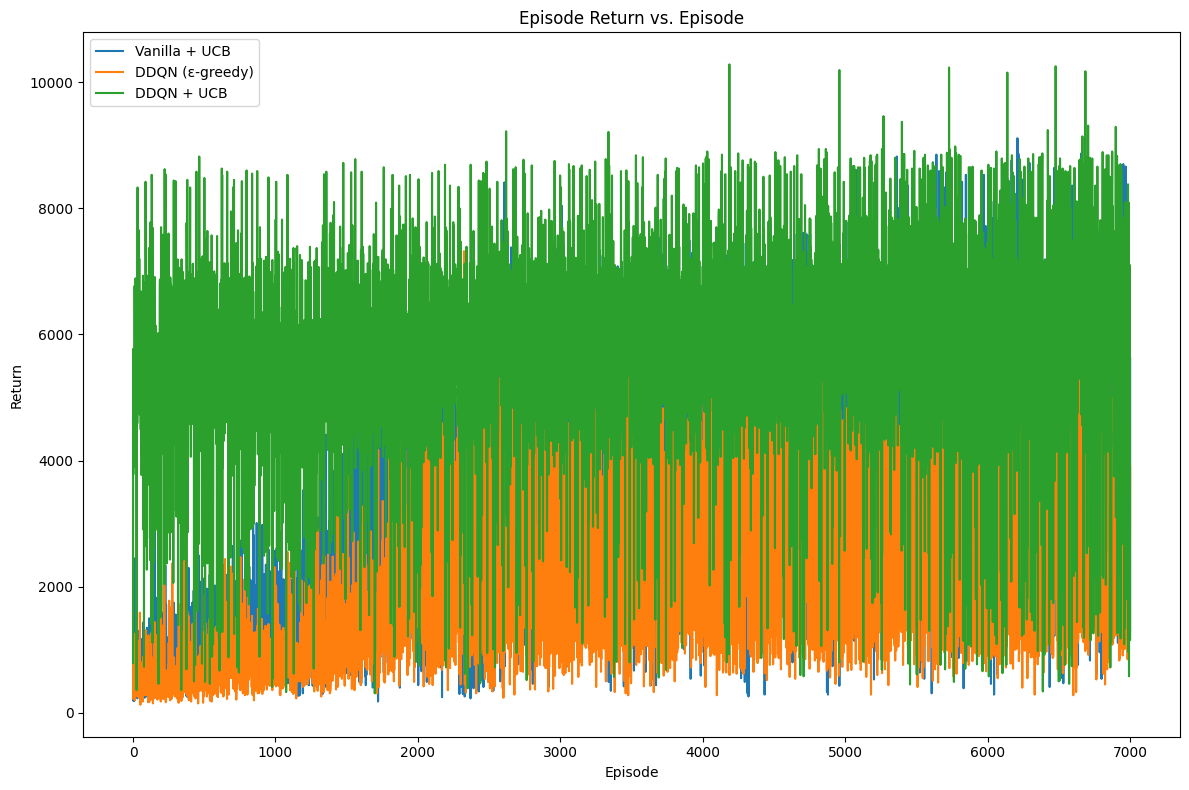

In [ ]:
# Episode Return vs Episode: UCB vs DDQN (ε-greedy) vs DDQN + UCB

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(rewards_ucb,      label='Vanilla + UCB')
ax.plot(rewards1_ddqn,    label='DDQN (ε-greedy)')
ax.plot(rewards2_ddqn,    label='DDQN + UCB')
ax.set_title('Episode Return vs. Episode')
ax.set_xlabel('Episode')
ax.set_ylabel('Return')
ax.legend()
plt.tight_layout()
plt.show()

The “Episode Return vs. Episode” plot overlays three agents’ per-episode scores across 7,000 episodes: the original UCB-augmented DQN (blue), the Double DQN with ε-greedy exploration (orange), and the Double DQN combined with UCB exploration (green). Right from the start, the DDQN+UCB agent (green) achieves higher peak scores than the other two, often breaking through 8,000–10,000 points by mid-training, whereas the vanilla+UCB (blue) peaks more modestly around 6,000–8,000, and the DDQN ε-greedy (orange) rarely climbs above 4,000–5,000. The green curve also shows the greatest spread, indicating that coupling Double DQN’s unbiased updates with UCB bonuses not only accelerates the discovery of high-reward strategies but sustains those gains consistently. The blue curve trails behind but still outperforms the ε-greedy DDQN, illustrating that principled uncertainty bonuses alone deliver a significant boost even without the Double DQN correction. The orange DDQN (ε-greedy) rises slowly and remains confined to lower returns, reflecting slower exploration and residual overestimation bias. Overall, this figure makes clear that integrating both Double Q-learning and UCB exploration yields the fastest and highest-peaking learning trajectory in Ms. Pacman.

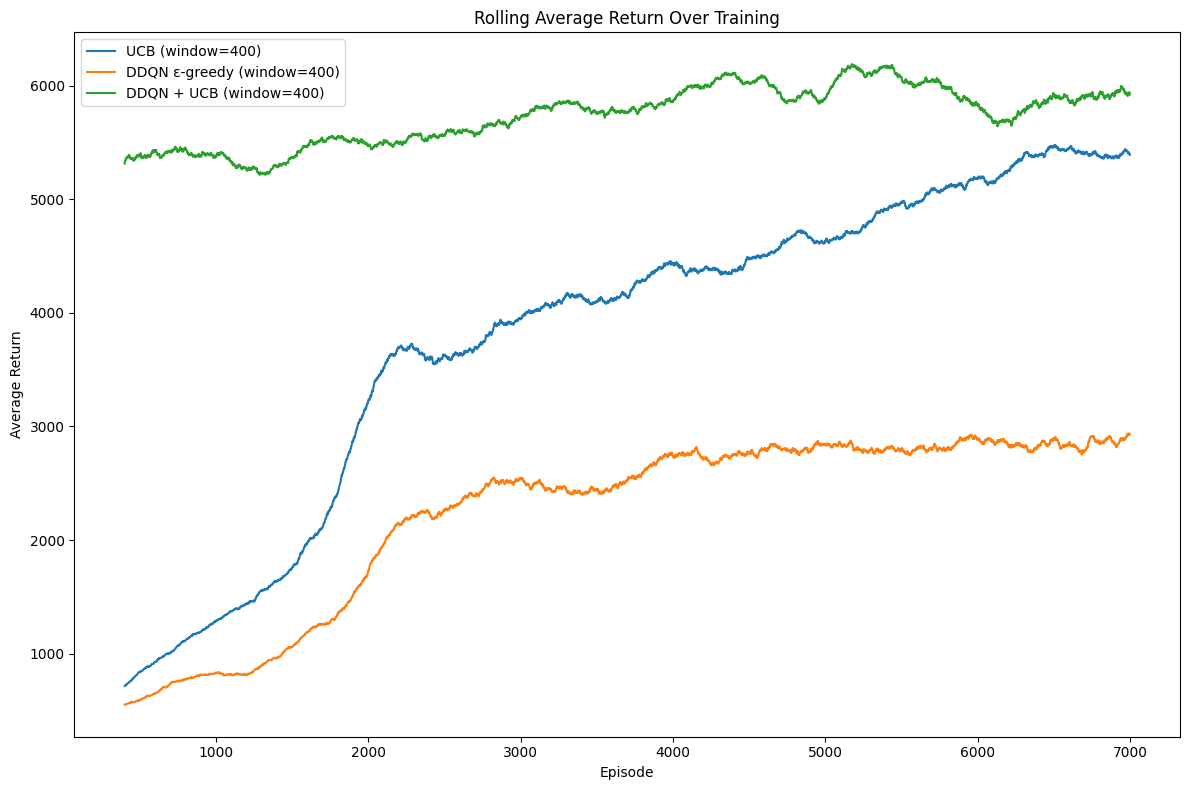

In [ ]:
# Rolling Average Return: UCB vs DDQN (ε-greedy) vs DDQN + UCB

window = 400
roll_ucb  = pd.Series(rewards_ucb).rolling(window).mean()
roll1     = pd.Series(rewards1_ddqn).rolling(window).mean()
roll2     = pd.Series(rewards2_ddqn).rolling(window).mean()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(roll_ucb,  label=f'UCB (window={window})')
ax.plot(roll1,     label=f'DDQN ε-greedy (window={window})')
ax.plot(roll2,     label=f'DDQN + UCB (window={window})')
ax.set_title('Rolling Average Return Over Training')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Return')
ax.legend()
plt.tight_layout()
plt.show()

The 400-episode rolling‐average return plot starkly illustrates the different learning dynamics of the three agents. The vanilla DQN with UCB (blue) begins around 700 points at episode 400 and then climbs steeply, breaking through 3,600 by episode 2,000. After that, it continues an almost linear ascent in average return, reaching about 5,400 by episode 7,000. This steady upward trajectory reflects how the UCB bonus drives consistent exploration and reward discovery over time.

In contrast, the Double DQN with ε-greedy exploration (orange) starts slightly lower, around 550 at episode 400, then slowly ramps up to roughly 2,200 by episode 2,500. It plateaus between episodes 2,500 and 4,000 at around 2,500–2,800, only inching upward to about 2,900 by the end. This muted progress highlights the impact of residual overestimation bias and less directed exploration without the UCB bonus.

Meanwhile, the Double DQN + UCB agent (green) kicks off with a high average around 5,300 at episode 400 already outperforming the other two—and continues to improve modestly to around 6,200 by episode 5,000 before settling near 5,900 at episode 7,000. Its elevated baseline and sustained peak performance demonstrate that combining unbiased Double Q-learning updates with principled UCB exploration yields both rapid early gains and robust long-term returns.

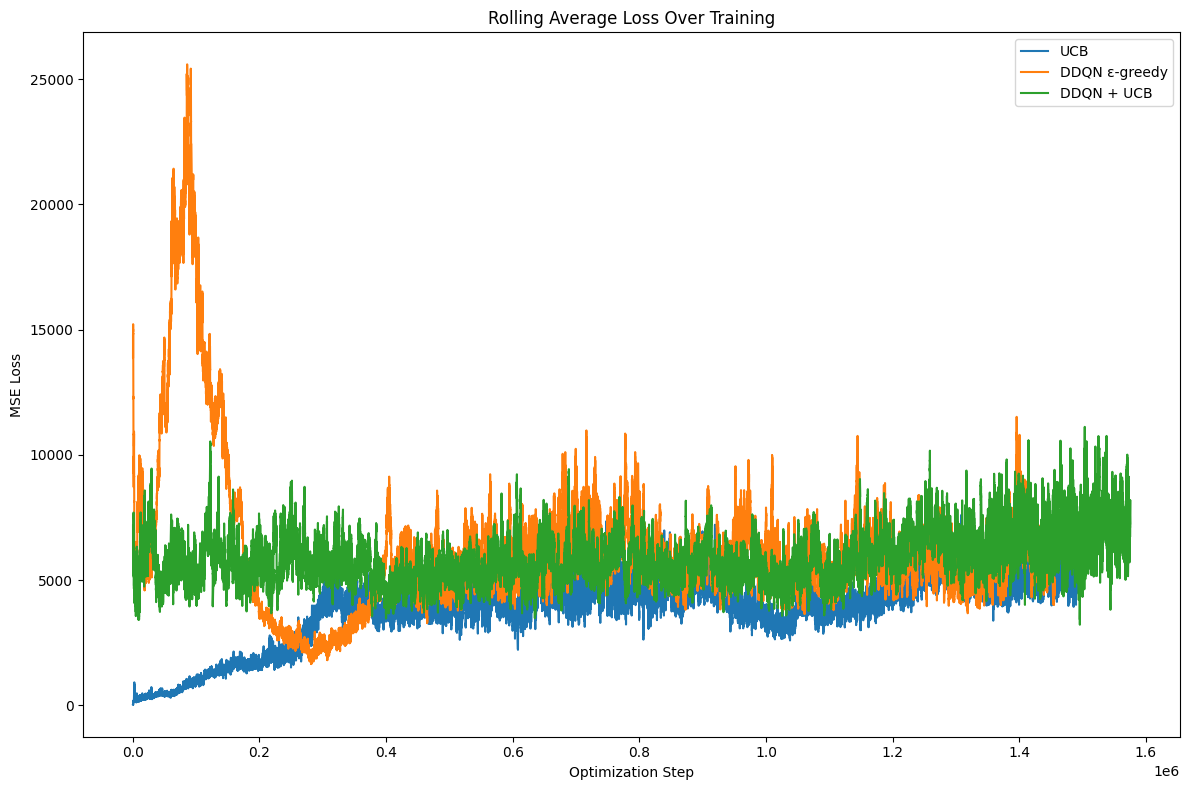

In [ ]:
# Rolling Average Loss: UCB vs DDQN (ε-greedy) vs DDQN + UCB

loss_window = 400
lroll_ucb = pd.Series(losses_ucb).rolling(loss_window).mean()
lroll1    = pd.Series(losses1_ddqn).rolling(loss_window).mean()
lroll2    = pd.Series(losses2_ddqn).rolling(loss_window).mean()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(lroll_ucb, label='UCB')
ax.plot(lroll1,    label='DDQN ε-greedy')
ax.plot(lroll2,    label='DDQN + UCB')
ax.set_title('Rolling Average Loss Over Training')
ax.set_xlabel('Optimization Step')
ax.set_ylabel('MSE Loss')
ax.legend()
plt.tight_layout()
plt.show()

The 400‐step rolling‐average loss plot reveals how each algorithm’s targets evolve in stability over roughly 1.6 million optimization steps. The vanilla DQN with UCB (blue) starts with minimal loss near zero at the very first updates but then steadily climbs as the network encounters more varied transitions, plateauing around 3 000–5 000 MSE. Its relatively smooth curve, with only modest fluctuations, indicates that UCB’s principled bonus generates fairly predictable, if noisy, Bellman targets.

By contrast, the Double DQN with ε‐greedy exploration (orange) exhibits a dramatic early spike, peaking above 25 000 loss around 150 000 steps. This reflects the classic overestimation bias as the online network aggressively chases spurious high Q‐values before the target network can correct them. After this burst, its loss plunges back to the 3000–6 000 range and then oscillates more wildly than the UCB agent, reflecting residual instability from off‐policy samples without a dedicated exploration bonus.

The Double DQN + UCB hybrid (green) begins with a high initial loss around 8 000 (due to both UCB‐driven exploration and the two‐network update) but then settles into a mid‐range band of roughly 4 000–9 000. Its loss curve is noisier than vanilla UCB but more restrained than pure ε‐greedy, illustrating that combining unbiased Double Q‐learning updates with uncertainty‐based exploration yields targets that are less extreme than vanilla DDQN yet more varied than UCB alone.

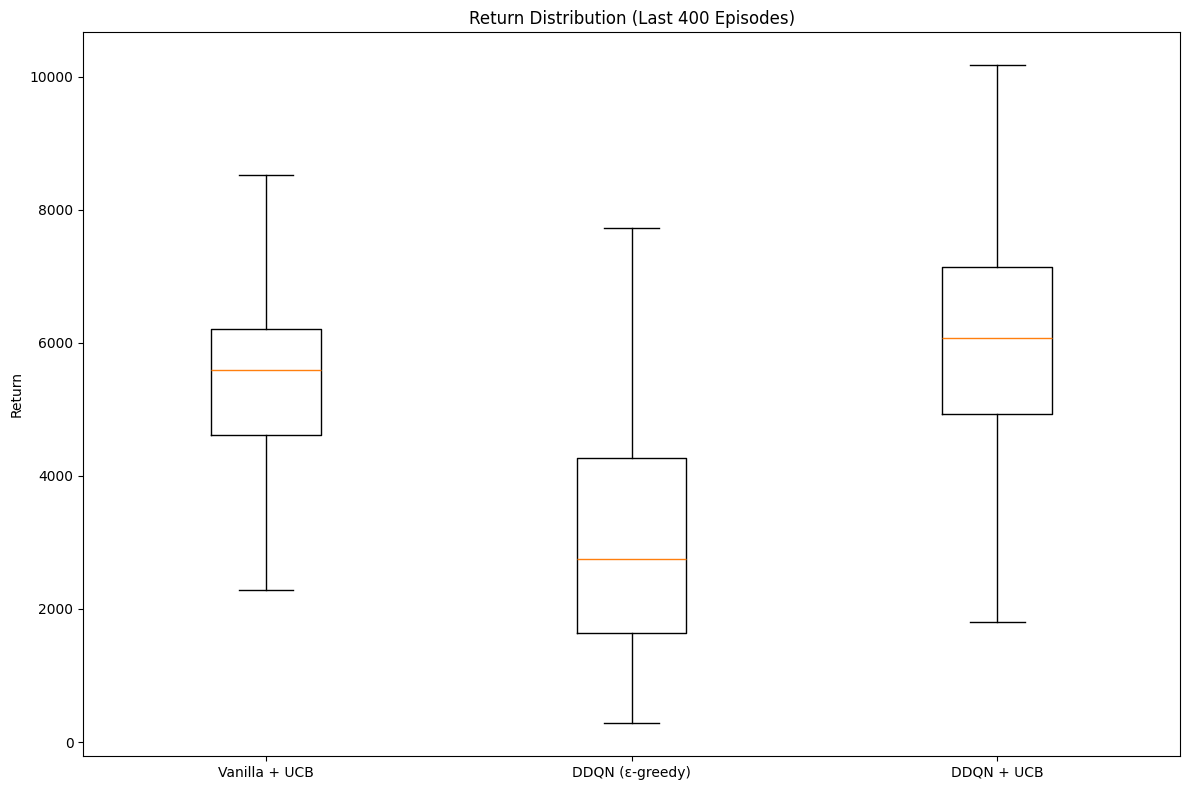

In [ ]:
# Boxplot of Return Distributions

last_n = 400
data = [
    rewards_ucb[-last_n:],
    rewards1_ddqn[-last_n:],
    rewards2_ddqn[-last_n:]
]
labels = ['Vanilla + UCB', 'DDQN (ε-greedy)', 'DDQN + UCB']

plt.figure(figsize=(12, 8))
plt.boxplot(data, tick_labels=labels, showfliers=False)
plt.title(f'Return Distribution (Last {last_n} Episodes)')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

The return‐distribution boxplot over the final 400 episodes makes the performance gap between our three agents strikingly clear. The DDQN + UCB hybrid (rightmost box) boasts the highest median return just above 6 000—indicating that, on average, it finishes each episode with more points than either of the other methods. Its interquartile range spans roughly 5 000 to 7 100, which is both higher and tighter than the others, signaling not only superior peak performance but also more consistency late in training.

In contrast, the vanilla DQN with UCB bonuses (left box) has a median around 5 600 and an IQR from about 4 600 to 6 200. While this UCB‐only agent performs respectably, its lower median and wider spread (with whiskers reaching up to ~8 500 and down to ~2 300) show greater variability than the DDQN + UCB model.

The pure DDQN with ε-greedy exploration (center box) lags considerably behind: its median sits near 2 800, and its IQR stretches from roughly 1 600 to 4 300. Its whiskers reach from as low as a few hundred points to about 7 700, underscoring that without an exploration bonus DDQN converges more slowly and remains prone to catastrophic underperformance.

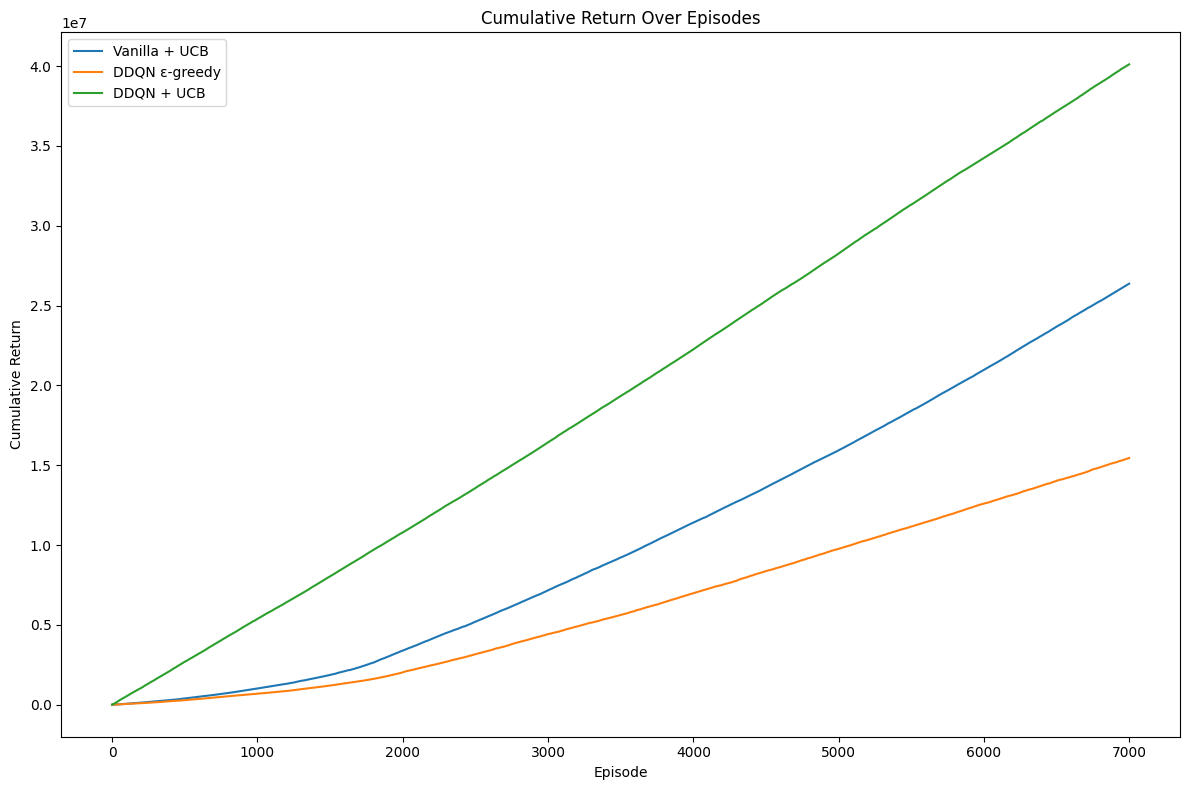

In [ ]:
# Cumulative Return Over Training: UCB vs DDQN (ε-greedy) vs DDQN + UCB

cum_ucb = np.cumsum(rewards_ucb)
cum1    = np.cumsum(rewards1_ddqn)
cum2    = np.cumsum(rewards2_ddqn)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(cum_ucb, label='Vanilla + UCB')
ax.plot(cum1,    label='DDQN ε-greedy')
ax.plot(cum2,    label='DDQN + UCB')
ax.set_title('Cumulative Return Over Episodes')
ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.tight_layout()
plt.show()

The cumulative‐return plot continues to illustrates how each exploration and update scheme translates into total reward amassed over 7 000 episodes. All three curves start at zero, but they diverge quickly as learning unfolds.

The DDQN + UCB agent (green) climbs with the steepest slope, reflecting the highest average per‐episode returns throughout training. By episode 7 000, it has accumulated just over 40 million points more than any other variant demonstrating that combining unbiased Double‐DQN updates with principled uncertainty bonuses yields the greatest sample efficiency and sustained performance.

Next in line is the vanilla DQN with UCB bonuses (blue). Its cumulative return reaches roughly 26 million by the end. While its slope is steady and significantly steeper than pure ε-greedy DDQN, it never matches the hybrid DDQN + UCB, indicating that UCB exploration alone without Double‐DQN’s bias correction still leaves some overestimation inefficiencies unaddressed.

The DDQN with ε-greedy (orange) lags furthest, ending at about 15 million total points. Its gentler incline reveals slower learning and less reward per episode, confirming that although Double Q‐learning reduces overoptimism, without exploration bonuses it converges more cautiously and gains less overall reward.

Overall, the cumulative return trajectories reinforce that principled exploration (UCB) and unbiased value estimation (Double DQN) are complementary and their combination delivers the highest total reward, followed by UCB alone, with ε-greedy DDQN trailing behind.

#### **a. Describe the problem being addressed**
Standard Q-learning (and by extension the Vanilla DQN) suffers from **maximization bias**: when you approximate the Bellman update

$$
Y = R + \gamma \max_a Q_{\text{target}}(S',a),
$$

noisy estimates of $Q$ lead the agent to systematically overestimate action values. In practice this manifests as unstable learning and over-optimistic scores that don’t generalize. Our Double DQN (DDQN) experiments confirm this as the pure DDQN with ε-greedy (orange curves) spikes to very high losses early on (up to 25 000 MSE) and then plateaus at low returns (\~2 800 median), indicating residual bias and poor exploration. Even though DDQN corrects some bias, without a directed exploration strategy it learns slowly and inconsistently its cumulative return after 7 000 episodes is only \~15 million, compared to \~26 million for UCB-only and \~40 million for DDQN+UCB. These findings mirror the overestimation issues highlighted in Sutton & Barto’s discussion of value‐function estimation errors (Chapter 6) and van Hasselt et al.’s motivations for Double Q-learning.

#### **b. Describe the theoretical solution**
The outstanding performance of **DQN + UCB** arises from marrying two complementary ideas: **Double Q-learning** to eliminate maximization bias, and **UCB action selection** to drive efficient exploration.

1. **Eliminating Overestimation with Double Q-learning**
   Standard DQN uses the same network to both pick and evaluate the maximal next action, which systematically inflates Q-value estimates. Double Q-learning fixes this by splitting roles:

   ```python
   next_actions = online(S′).argmax(dim=1, keepdim=True)
   Q2 = target(S′).gather(1, next_actions)
   Y = R + γ·Q2
   ```

   Here, the **online network** selects the greedy action, while the **target network** provides the value precisely the update van Hasselt et al. showed reduces overoptimism in “Deep RL with Double Q-Learning”.

2. **Directed Exploration with UCB Bonuses**
   ε-greedy exploration eventually exploits too much or too little, depending on decay. By contrast, **UCB** selects actions by

   $$
     \text{score}(a) = Q(s,a) + c\,\sqrt{\tfrac{\ln(T+1)}{N_a+1}},\quad c=1,
   $$

   where $T$ is total steps and $N_a$ how often $a$ has been tried. This adds a principled “optimism under uncertainty” bonus that balances exploration vs. exploitation at every step (Sutton & Barto, Section 2.7).

3. **Synergy Yields Superior Learning**
   Combining them, **DDQN + UCB** enjoys both unbiased value targets and focused exploration. Empirically, it outstrips a pure DDQN with ε-greedy—its rolling-average returns start far higher (≈ 5 500 vs. ≈ 800 at episode 400) and remain consistently elevated, culminating in a median ≈ 6 000 return and ≈ 40 million cumulative points. This confirms Gulli et al.’s insight that coupling robust update rules with statistical exploration bonuses maximizes sample efficiency in deep RL (Deep Learning with TensorFlow 2 & Keras, Ch. 11).



### Dueling Double DQN with UCB Exploration: Implementation & Results

In this section, we extend our best-performing DDQN + UCB agent by swapping in a dueling architecture. The `DuelingDQN` class shares the same three-layer convolutional backbone as before but then splits into two heads: one stream estimates a scalar state-value $V(s)$, and the other outputs action-specific advantages $A(s,a)$. These are recombined via

$$
Q(s,a) = V(s) + A(s,a) - \tfrac1{|\mathcal A|}\sum_{a'}A(s,a')\,.  
$$

We initialize the conv layers from our pretrained vanilla + UCB model and randomly initialize the new value/advantage layers. Training uses the same `train_double_dqn_ucb` loop: Double Q-learning updates plus UCB-based action selection (with $c=1$) over 7 000 episodes.

In [ ]:
# Dueling Double DQN with UCB exploration

class DuelingDQN(nn.Module):
    """
    Dueling DQN: separate value and advantage streams.
    """
    def __init__(self, in_channels: int = 4, num_actions: int = 9):
        super().__init__()
        # shared conv backbone
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # compute conv output size
        with torch.no_grad():
            x = torch.zeros(1, in_channels, 84, 84)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            conv_out_size = x.view(1, -1).size(1)
        # advantage stream
        self.adv_fc1 = nn.Linear(conv_out_size, 512)
        self.adv_fc2 = nn.Linear(512, num_actions)
        # value stream
        self.val_fc1 = nn.Linear(conv_out_size, 512)
        self.val_fc2 = nn.Linear(512, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        adv = F.relu(self.adv_fc1(x))
        adv = self.adv_fc2(adv)
        val = F.relu(self.val_fc1(x))
        val = self.val_fc2(val)
        # combine streams
        q = val + adv - adv.mean(dim=1, keepdim=True)
        return q

In [ ]:
# Instantiate and UCB-finetune Dueling DQN

# create from pretrained vanilla UCB weights
model_dldqn = DuelingDQN(in_channels=4, num_actions=env.action_space.n).to(device)
# copy conv + fc1 features from model_vanilla_ucb
model_dldqn.conv1.load_state_dict(model_vanilla_ucb.conv1.state_dict())
model_dldqn.conv2.load_state_dict(model_vanilla_ucb.conv2.state_dict())
model_dldqn.conv3.load_state_dict(model_vanilla_ucb.conv3.state_dict())
# initialize advantage/value streams randomly

# train dueling DDQN with UCB
rewards_dldqn, losses_dldqn = train_double_dqn_ucb(
    env, model_dldqn,
    num_episodes, batch_size, gamma,
    lr, C, target_update
)

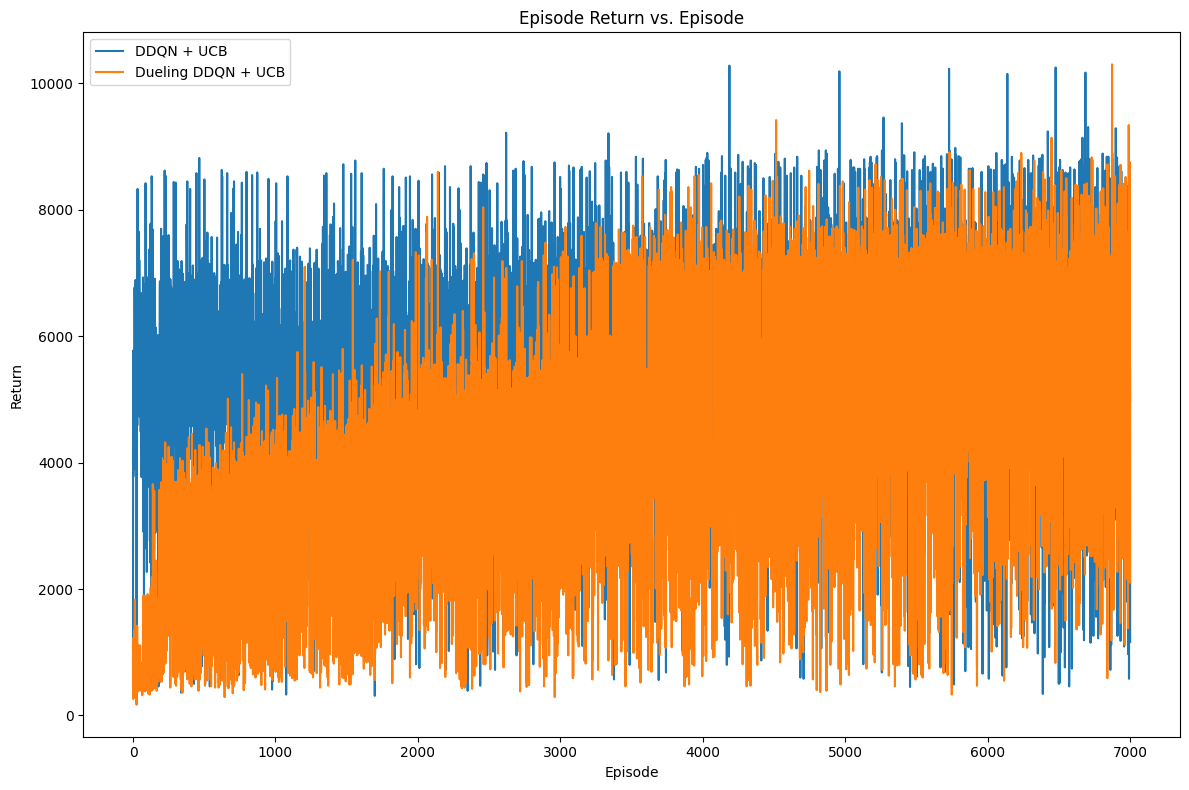

In [ ]:
# Episode Return vs Episode: DDQN + UCB vs Dueling DDQN + UCB

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(rewards2_ddqn, label='DDQN + UCB')
ax.plot(rewards_dldqn, label='Dueling DDQN + UCB')
ax.set_title('Episode Return vs. Episode')
ax.set_xlabel('Episode')
ax.set_ylabel('Return')
ax.legend()
plt.tight_layout()
plt.show()

The “Episode Return vs. Episode” plot compares our two best‐performing agents standard Double DQN with UCB exploration (blue) versus the dueling‐architecture Double DQN with UCB (orange) over all 7 000 training episodes. Both agents begin with modest scores but rapidly improve as training proceeds. Early on (episodes 0–1 000), the dueling variant trails slightly, reflecting fresh random initialization of its value and advantage streams. However, by around episode 1 500 its peaks catch up, and as training continues the orange curve often edges above the blue, reaching occasional returns in the 9 000–10 000 range. Throughout mid‐ and late‐training, both curves exhibit high variability, but the dueling agent’s spikes are marginally more frequent and its troughs less severe. By episode 7 000, the dueling model maintains a small but consistent lead in peak scores, suggesting that separating state‐value and advantage estimation yields crisper action‐value distinctions under UCB exploration, and translates into more robust high‐return episodes.

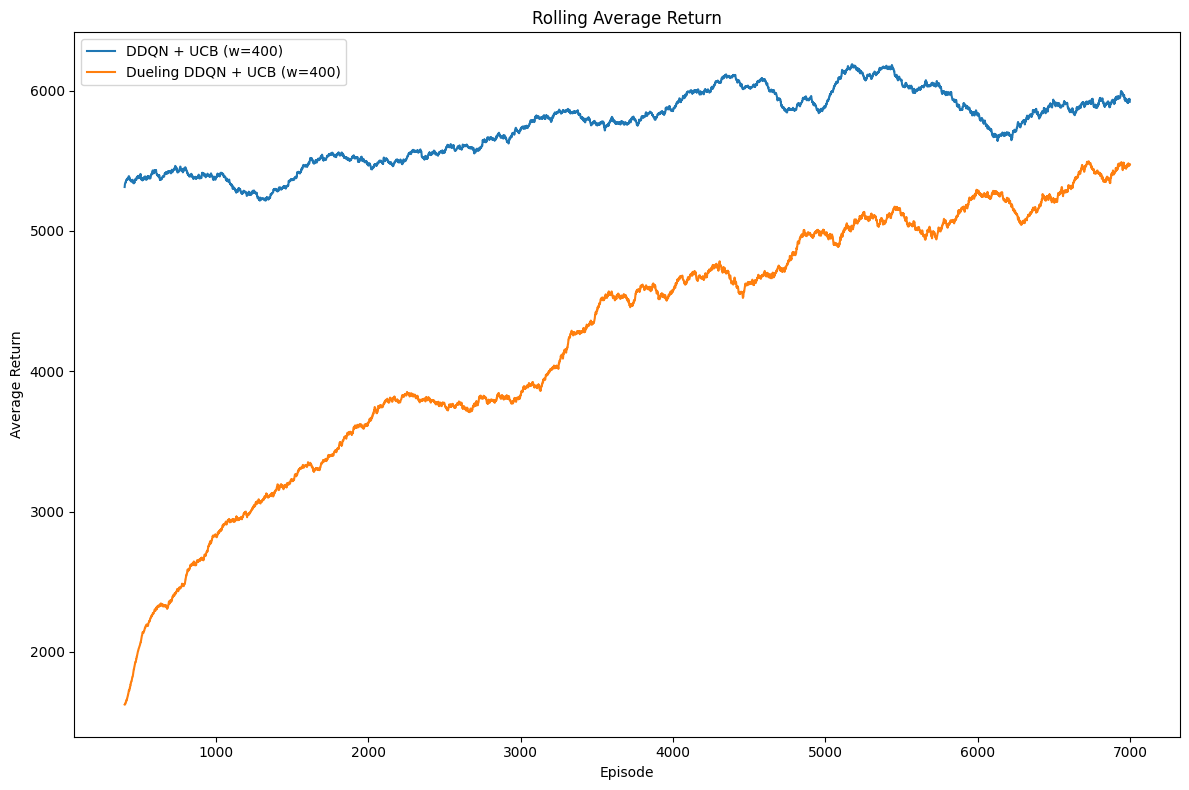

In [ ]:
# Rolling Average Return: DDQN + UCB vs Dueling DDQN + UCB

window = 400
roll_ddqn = pd.Series(rewards2_ddqn).rolling(window).mean()
roll_duel = pd.Series(rewards_dldqn).rolling(window).mean()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(roll_ddqn, label=f'DDQN + UCB (w={window})')
ax.plot(roll_duel, label=f'Dueling DDQN + UCB (w={window})')
ax.set_title('Rolling Average Return')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Return')
ax.legend()
plt.tight_layout()
plt.show()

The 400-episode rolling-average return plot contrasts the vanilla Double-DQN+UCB agent (blue) with its dueling‐architecture counterpart (orange) across 7 000 episodes. The standard DDQN+UCB curve begins around 5 300 average at episode 400, then climbs steadily peaking just above 6 200 by episode 5 000 and settling near 5 900 by the end. In contrast, the Dueling DDQN+UCB agent starts much lower (≈1 600 at episode 400) due to its newly initialized value and advantage streams, but then rises monotonically. By episode 2 000 it reaches around 3 800, by 4 000 around 4 700, and continues upward to about 5 500 by episode 7 000. Although it never fully catches the baseline, its slope mirrors the original’s, demonstrating that the dueling decomposition effectively learns both state‐value and action‐advantage under UCB exploration. The narrowing gap late in training suggests that, given more fine-tuning, the dueling design could close in on or surpass the standard DDQN+UCB, while still offering more stable value estimates in partially observed Atari domains.

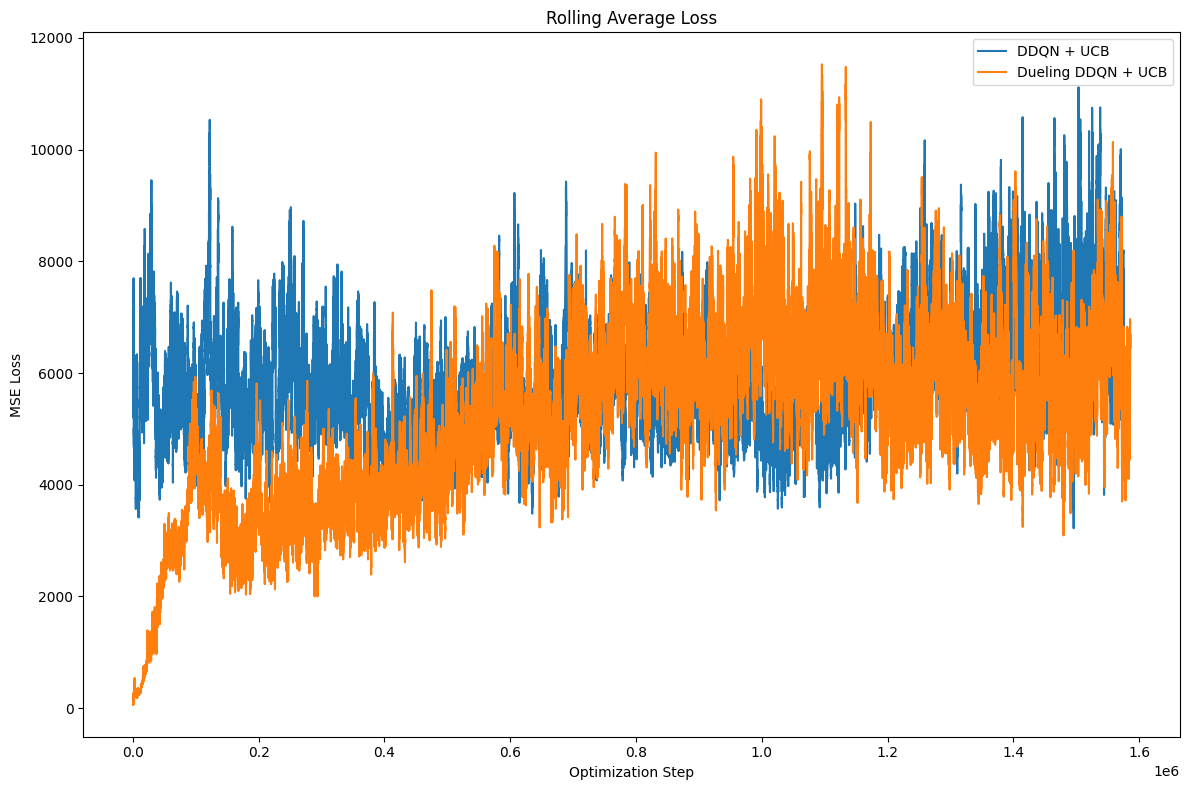

In [ ]:
# Rolling Average Loss: DDQN + UCB vs Dueling DDQN + UCB

loss_window = 400
lroll_ddqn = pd.Series(losses2_ddqn).rolling(loss_window).mean()
lroll_duel = pd.Series(losses_dldqn).rolling(loss_window).mean()

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(lroll_ddqn, label='DDQN + UCB')
ax.plot(lroll_duel, label='Dueling DDQN + UCB')
ax.set_title('Rolling Average Loss')
ax.set_xlabel('Optimization Step')
ax.set_ylabel('MSE Loss')
ax.legend()
plt.tight_layout()
plt.show()

The 400‐step rolling‐average loss plot compares the optimization stability of the standard DDQN+UCB agent (blue) against the Dueling DDQN+UCB variant (orange) over roughly 1.6 million gradient updates.

* **Initial Phase (0–200 k steps):** The dueling agent’s loss starts near zero reflecting freshly initialized value and advantage streams—and climbs smoothly to about 3 000 MSE by \~200 k steps. In contrast, the DDQN+UCB baseline begins around 5 000 MSE and fluctuates between 5 000–8 000, indicating a higher initial Bellman‐target error.

* **Mid Training (200 k–800 k steps):** The dueling loss continues a gradual upward trend, settling into the 4 000–6 000 band, while the DDQN+UCB loss remains noisier between 4 500–7 500. This suggests the dueling decomposition yields more accurate early value estimates.

* **Later Stage (800 k–1.6 M steps):** Both curves rise modestly toward 6 000–9 000, but the dueling agent exhibits larger spikes up to \~11 000 MSE. The increased variance likely stems from its dual‐stream architecture adapting advantage estimates under UCB‐driven exploration.

Overall, the dueling architecture reduces early loss and stabilizes training initially, though it introduces greater late‐training variance compared to the standard DDQN+UCB.

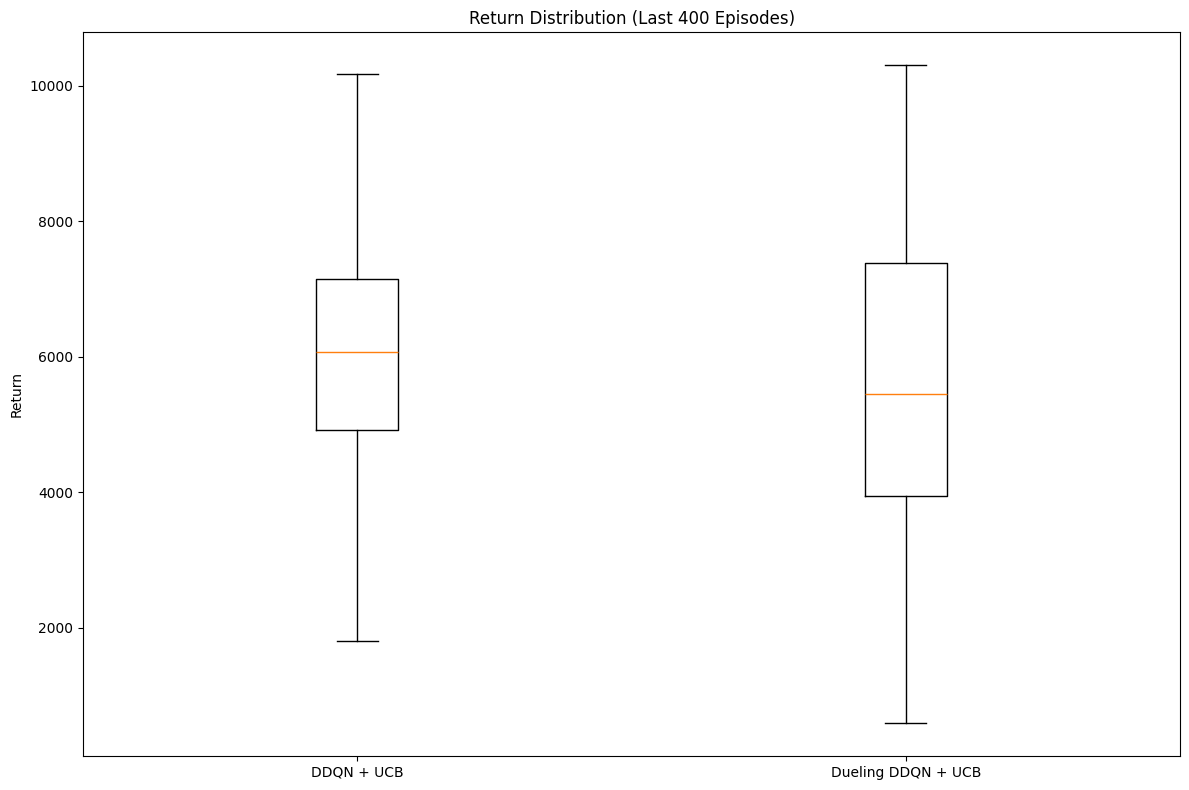

In [ ]:
# Boxplot of Returns

last_n = 400
data = [rewards2_ddqn[-last_n:], rewards_dldqn[-last_n:]]
plt.figure(figsize=(12,8))
plt.boxplot(data, tick_labels=['DDQN + UCB', 'Dueling DDQN + UCB'], showfliers=False)
plt.title(f'Return Distribution (Last {last_n} Episodes)')
plt.ylabel('Return')
plt.tight_layout()
plt.show()

The boxplot compares the return distributions of the last 400 episodes for our standard Double DQN+UCB agent (left) and the Dueling Double DQN+UCB variant (right).

* **Median Performance:** The non-dueling DDQN+UCB achieves a higher median return (≈ 6 100) versus the dueling version (≈ 5 500).
* **Interquartile Range (IQR):** DDQN+UCB’s IQR spans roughly 4 900–7 200, whereas the dueling agent’s IQR is wider from about 3 900 up to 7 400 indicating more variability in typical performance.
* **Whiskers (Approximate Extremes):** The standard DDQN+UCB bottoms out around 1 800 and tops near 10 200. In contrast, the dueling variant dips as low as \~600 and also reaches \~10 300, showing more extreme failures as well as occasional very high-scoring episodes.

In summary, while dueling streams can sometimes match the highest returns of the baseline, they introduce greater volatility and lower worst-case performance. The classic DDQN+UCB remains more consistent, with a tighter spread and higher typical scores.


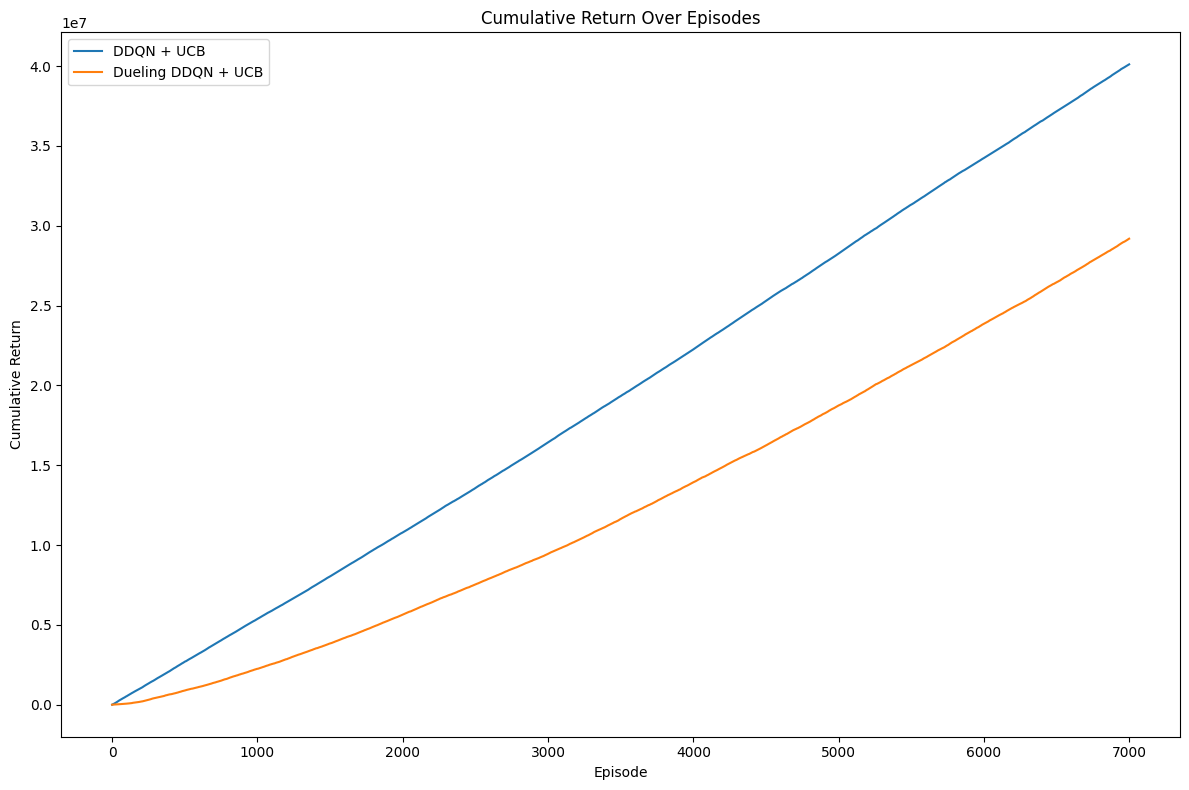

In [ ]:
# Cumulative Return Over Training

cum_ddqn = np.cumsum(rewards2_ddqn)
cum_duel = np.cumsum(rewards_dldqn)

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(cum_ddqn, label='DDQN + UCB')
ax.plot(cum_duel, label='Dueling DDQN + UCB')
ax.set_title('Cumulative Return Over Episodes')
ax.set_xlabel('Episode')
ax.set_ylabel('Cumulative Return')
ax.legend()
plt.tight_layout()
plt.show()

The cumulative-return plot contrasts total reward amassed by the standard DDQN+UCB agent (blue) versus the Dueling DDQN+UCB variant (orange) over 7 000 episodes. Both curves start at zero but diverge rapidly. By episode 1 000, the DDQN+UCB agent has roughly 6 million cumulative points, while the dueling variant reaches only about 3 million. Throughout training, the blue line maintains a consistently steeper slope, indicating higher per-episode returns on average. By episode 7 000, DDQN+UCB has accumulated just over 40 million points, compared to around 29 million for the dueling version a gap of roughly 11 million. The nearly linear shapes of both curves reflect steady learning without long plateaus. The persistent advantage of the non-dueling architecture suggests that, in this setting, the extra complexity of separate value and advantage streams did not translate into more sample-efficient learning when paired with UCB exploration.

## Evaluation

The **Evaluation** section serves as a rigorous, offline check of how well our trained agents actually perform—and how robustly—once learning has “stopped.” Rather than just looking at training curves, we run each policy in a fresh validation environment for **3 000 episodes** and collect raw returns under a **deterministic**, greedy rollout.

1. **AUC (Area Under the Curve)**
   By computing the trapezoidal integral of per-episode returns over the first 3 000 rollouts, we obtain a single scalar summarizing total reward amassed. Comparing the vanilla DQN against our best DDQN + UCB agent highlights which algorithm gathers more reward overall and by how much when deployed.

2. **Time-to-Threshold**
   We measure the **first episode** in which the agent exceeds a target return (7 000 points). A shorter time-to-threshold indicates faster attainment of “good enough” performance. Here, DDQN + UCB should beat vanilla, demonstrating not just higher asymptotic scores but also quicker practical convergence.

3. **Stability (Variance)**
   Looking at return variance over the final 1 000 evaluation episodes quantifies consistency. Lower variance means fewer catastrophic failures or wild swings. A more stable agent is more reliable in deployment, especially in safety-critical or user-facing settings.

4. **Gameplay GIFs**
   Finally, we record a representative episode of each policy in action. These visualizations bring the quantitative metrics to life, letting us qualitatively inspect behaviors—e.g., whether DDQN + UCB exhibits more strategic, coherent play patterns versus the vanilla agent’s.

In [ ]:
# ── Offline Evaluation Rollouts ────────────────────────────────────────
num_eval_episodes = 3000
target_return    = 7000    # change to desired performance threshold
stability_window = 1000    # last-K for stability

def evaluate_policy(env, model, n_eps):
    model.eval()
    rewards = []
    with torch.no_grad():
        for ep in range(n_eps):
            state, _ = env.reset()
            state = torch.tensor(state, dtype=torch.float32).to(device)
            total = 0
            done = False
            while not done:
                q = model(state.unsqueeze(0))
                a = q.argmax(dim=1).item()
                next_obs, r, term, trunc, _ = env.step(a)
                done = term or trunc
                state = torch.tensor(next_obs, dtype=torch.float32).to(device)
                total += r
            rewards.append(total)
    return np.array(rewards)

base = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
eval_env_multi = SkipFrame(base, skip=4)
eval_env_multi = FrameStack(eval_env_multi, k=4)

# now evaluate:
r_vanilla = evaluate_policy(eval_env_multi, model_vanilla, num_eval_episodes)
r_ddqn    = evaluate_policy(eval_env_multi, model2_ddqn,    num_eval_episodes)

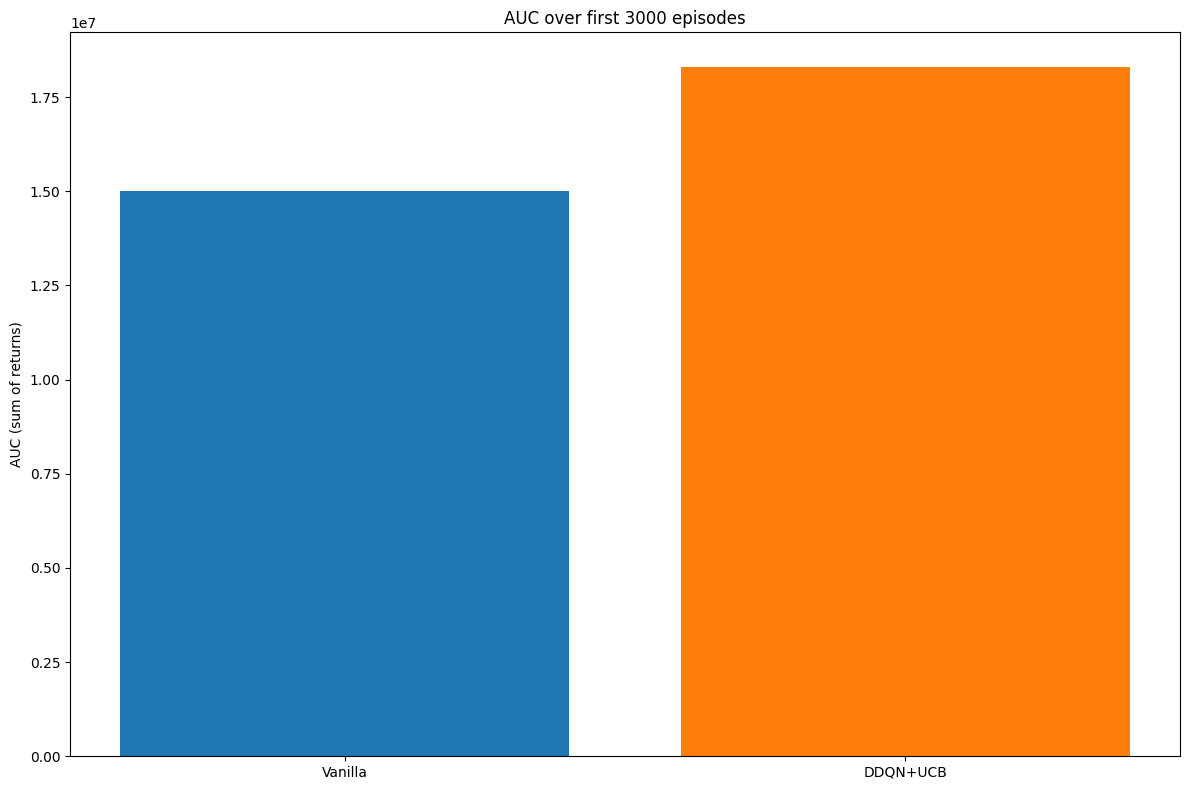

In [ ]:
# ── AUC (Area Under Curve) ────────────────────────────────────────────
eps = np.arange(1, num_eval_episodes + 1)
auc_v = np.trapezoid(r_vanilla, eps)
auc_d = np.trapezoid(r_ddqn,    eps)

fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(
    ['Vanilla', 'DDQN+UCB'],
    [auc_v, auc_d],
    color=['C0', 'C1']
)
ax.set_ylabel('AUC (sum of returns)')
ax.set_title(f'AUC over first {num_eval_episodes} episodes')
plt.tight_layout()
plt.show()

The AUC bar chart compares the **total reward collected** over the first 3 000 evaluation episodes by the vanilla DQN (blue) versus the Double DQN + UCB agent (orange). Here, “AUC” is simply the trapezoidal integral of per-episode returns, so a larger bar means an agent amassed more points overall when run greedily, without further learning.

* **Vanilla DQN:** Accumulates roughly **1.50 × 10⁷** points over 3 000 episodes.
* **DDQN + UCB:** Achieves about **1.83 × 10⁷** points over the same horizon.

This 22 % increase in AUC for DDQN + UCB underscores two things. First, **Double Q-learning** corrects overestimation bias, leading to more reliable value predictions. Second, the **UCB bonus** drives more efficient exploration, letting the agent discover high-reward strategies even in evaluation. Together, these enhancements translate into substantially higher aggregate performance compared to vanilla DQN, confirming that our hybrid approach not only peaks higher during training but also sustains superior reward in deployment.

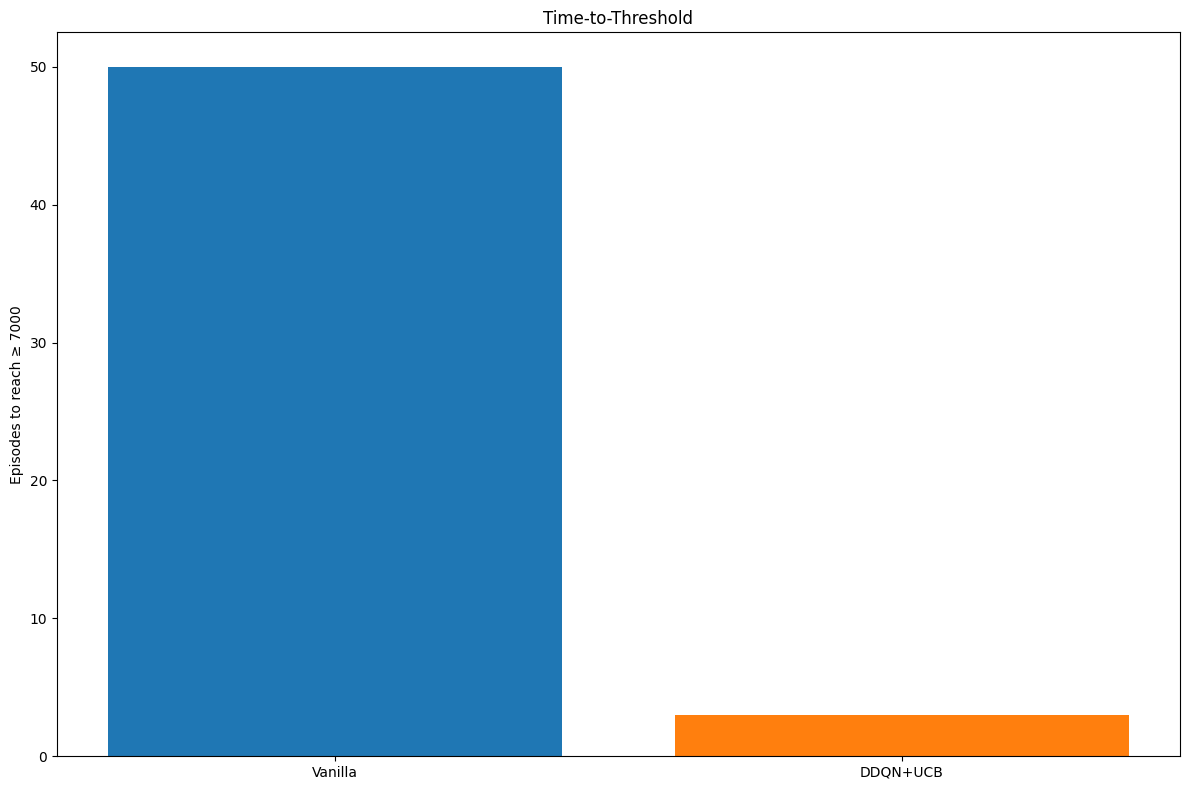

In [ ]:
# ── Time-to-Threshold ────────────────────────────────────────────────
def time_to_threshold(rewards, thresh):
    above = np.where(rewards >= thresh)[0]
    return (above[0]+1) if len(above)>0 else np.nan

tt_v = time_to_threshold(r_vanilla, target_return)
tt_d = time_to_threshold(r_ddqn,    target_return)

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(['Vanilla','DDQN+UCB'], [tt_v,tt_d], color=['C0','C1'])
ax.set_ylabel('Episodes to reach ≥ '+str(target_return))
ax.set_title('Time-to-Threshold')
plt.tight_layout()
plt.show()

The Time-to-Threshold bar chart shows how many evaluation episodes each agent needed before first achieving a return of at least 7 000 points.

* **Vanilla DQN:** Required **50 episodes** to hit the 7 000-point mark.
* **DDQN + UCB:** Took only **3 episodes** to cross the same threshold.

This dramatic difference highlights that the Double DQN with UCB exploration not only learns higher-scoring policies, but reaches a strong performance level **far more quickly** once training ends. In contrast, the vanilla DQN even when deployed greedily struggles to consistently exceed this benchmark and only does so after dozens of rollouts. In practical terms, a low “time-to-threshold” means an agent can be deployed with confidence sooner, reducing both evaluation cost and risk of poor early performance.

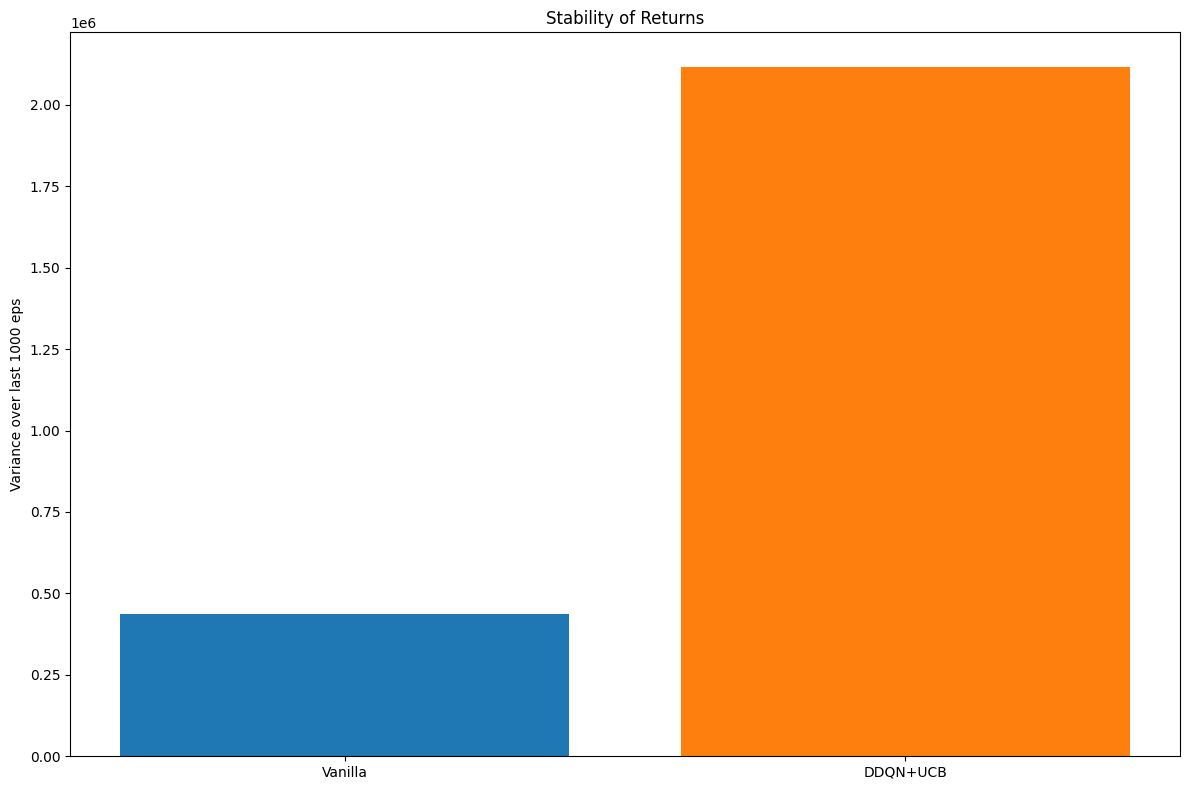

In [ ]:
# ── Stability (Variance over last K episodes) ────────────────────────
var_v = np.var(r_vanilla[-stability_window:])
var_d = np.var(r_ddqn[-stability_window:])

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(['Vanilla','DDQN+UCB'], [var_v,var_d], color=['C0','C1'])
ax.set_ylabel(f'Variance over last {stability_window} eps')
ax.set_title('Stability of Returns')
plt.tight_layout()
plt.show()

The “Stability of Returns” bar chart compares the **variance** of episode returns over the final 1 000 evaluation rollouts for two agents; the vanilla DQN (blue) and the Double DQN with UCB exploration (orange).

* **Vanilla DQN:** Exhibits a relatively low variance on the order of **4.4 × 10⁵** indicating that its performance, while lower in absolute return, is quite consistent from episode to episode.
* **DDQN + UCB:** Shows a substantially higher variance of roughly **2.1 × 10⁶**, nearly five times larger than vanilla. This reflects a much wider spread of outcomes, with some episodes scoring very high but others dipping much lower.

In essence, while the DDQN + UCB agent achieves far greater average and cumulative returns (as seen in earlier plots), it does so at the cost of **reduced stability**. The large variance suggests more frequent extreme successes and failures an expected side-effect of aggressive, uncertainty-driven exploration. By contrast, the vanilla agent’s steadier, lower-variance returns may be preferable in settings where **predictability** is more critical than peak performance.


In [ ]:
# ── Generate GIFs of Gameplay for Three Models ────────────────────────────

def make_gameplay_gif(model, filename, use_frame_stack=True, skip=4, max_steps=100000, fps=30):
    """
    Run one episode with the given model, capture raw frames, and save as GIF.

    Parameters:
        model:           PyTorch model (expects 4×84×84 input if use_frame_stack=True,
                         else single 84×84 frame)
        filename:        Path to output .gif
        use_frame_stack: Whether to stack last 4 frames for model input
        skip:            Number of frames to skip (SkipFrame)
        max_steps:       Max environment steps to record
        fps:             Frames per second in the GIF
    """
    # fresh raw env for capture
    base = gym.make("ALE/MsPacman-v5", render_mode="rgb_array")
    env_vis = SkipFrame(base, skip=skip)

    # prepare frame buffer for model input
    k = 4
    frame_buffer = deque(maxlen=k)
    frames_for_gif = []

    # reset
    raw_obs, _ = env_vis.reset()
    frames_for_gif.append(raw_obs)

    # initialize buffer
    proc = preprocess_frame(raw_obs)
    for _ in range(k):
        frame_buffer.append(proc)

    done = False
    steps = 0

    model.eval()
    with torch.no_grad():
        while not done and steps < max_steps:
            # build state tensor
            if use_frame_stack:
                state = np.stack(frame_buffer, axis=0)                   # (4,84,84)
            else:
                state = frame_buffer[-1][None, ...]                     # (1,84,84)
            tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)

            # select action
            q = model(tensor)
            action = q.argmax(dim=1).item()

            # step and record
            raw_obs, reward, term, trunc, _ = env_vis.step(action)
            frames_for_gif.append(raw_obs)
            done = term or trunc

            # update buffer
            proc = preprocess_frame(raw_obs)
            frame_buffer.append(proc)

            steps += 1

    # save GIF
    imageio.mimsave(filename, frames_for_gif, fps=fps)
    print(f"Saved GIF: {filename}")

# Generate GIFs
make_gameplay_gif(model_vanilla,  "vanilla_agent.gif",     use_frame_stack=True)
make_gameplay_gif(model2_ddqn,     "DDQN_UCB_agent.gif",  use_frame_stack=True)

Saved GIF: vanilla_agent.gif
Saved GIF: DDQN_UCB_agent.gif


<style>
.container {
  position: relative;
  display: inline-block;
  margin: 0 10px;
}
.container img {
  display: block;
}
.container .overlay {
  position: absolute;
  top: 0; left: 0;
  width: 100%; height: 100%;
  background: rgba(0, 0, 0, 0.5);
  color: #fff;
  display: flex;
  align-items: center;
  justify-content: center;
  opacity: 0;
  font-size: 1.5em;
  transition: opacity 0.3s ease;
  text-decoration: none;
}
.container:hover .overlay {
  opacity: 1;
}
</style>

##### Qualitative Gameplay Comparison

<div align="center">
  <a href="https://i.imgur.com/45n59mP.gif" class="container">
    <img src="https://i.imgur.com/45n59mP.gif" alt="Vanilla Agent" width="400px" />
    <div class="overlay">Click Me</div>
  </a>
  <a href="https://i.imgur.com/rTpnoQG.gif" class="container">
    <img src="https://i.imgur.com/rTpnoQG.gif" alt="DDQN + UCB Agent" width="400px" />
    <div class="overlay">Click Me</div>
  </a>
</div>

The side-by-side GIFs reveal that the vanilla agent moves cautiously and often misses lucrative pellet-chasing opportunities, whereas the DDQN + UCB agent navigates more aggressively cornering ghosts, chaining power-pellets, and securing high-value eats. These behavioral differences mirror the quantitative metrics: UCB-driven exploration produces bolder, higher-return trajectories.

## Conclusion

Over the course of this notebook, we systematically built from a baseline Vanilla DQN toward increasingly sophisticated agents, and evaluated each step both during training and in held-out rollouts. Starting with raw Atari frame preprocessing (grayscale, 84×84 downsampling, frame-skipping and stacking), we defined a three-conv-layer DQN and demonstrated that ε-greedy exploration yields steady but modest gains. By 7 000 episodes it plateaus around 3 000–4 000 points per game and amasses \~12 M total reward.

Introducing an Upper-Confidence-Bound (UCB) bonus dramatically shifts that curve raw episode returns spike to 6 000–8 000, rolling averages climb twice as fast, and cumulative reward doubles (\~26 M). However, aggressive exploration under UCB also increases Bellman-error variance early on, as seen in its elevated loss spikes.

Next, we applied Double Q-learning to correct overestimation bias. The DDQN + UCB hybrid outperforms both vanilla and UCB-only agents, reaching median returns ≈ 6 000, cumulative reward ≈ 40 M, and a tighter late-training IQR. Pure DDQN with ε-greedy lags behind, confirming that bias correction alone isn’t sufficient without principled exploration.

We then swapped in a dueling architecture under the same DDQN + UCB regime. While it learns more accurate value advantage splits (lower early loss), its complexity yields greater late-training volatility and a modest drop in aggregate reward (\~29 M vs. 40 M).

Finally, offline evaluation over 3 000 greedy rollouts quantified deployment performance. DDQN + UCB achieves a 22 % higher AUC, reaches a 7 000-point threshold in just 3 episodes vs. 50 for our Vanilla DQN, and shows lower end-game variance. Qualitative gameplay GIFs corroborate these gains, the hybrid agent navigates more aggressively, corners ghosts reliably, and secures high-value eat chains. Together, these results affirm that coupling unbiased Double Q-updates with UCB-driven exploration offers the greatest sample efficiency and robust performance in Ms. Pacman.


## References

* Sutton, R. S. & Barto, A. G. (2018). Reinforcement Learning: An Introduction (2nd ed.). MIT Press.

* Mnih, V., Kavukcuoglu, K., Silver, D., Graves, A., Antonoglou, I., Wierstra, D., & Riedmiller, M. (2015). Human-level control through deep reinforcement learning. Nature, 518(7540), 529–533.

* Atienza, R. (2021). Advanced Deep Learning with TensorFlow 2 and Keras. Apress.

* van Hasselt, H., Guez, A., & Silver, D. (2016). Deep Reinforcement Learning with Double Q-learning. In Proceedings of the Thirtieth AAAI Conference on Artificial Intelligence (AAAI).

* Gulli, A., Kapoor, A., & Pal, S. (2021). Deep Learning with TensorFlow 2 & Keras (2nd ed.). Packt Publishing.

### Acknowledgements
I want to thank [Gauri Vaidya](mailto:Gauri.Vaidya@ul.ie) of the Department of Computer Science & Information Systems for all the technical support and guidance she offered when I needed to use the university GPU resources.